In [1]:
import os
import gc
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from PIL import Image
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch
import pandas as pd
import json
from skimage.measure import label, regionprops

pl.seed_everything(42, workers=True)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Seed set to 42


Using device: cuda


In [14]:
# Define your paths
TRAIN_IMG_DIR = '../CamVid/train/'
TRAIN_DEPTH_DIR = '../CamVid/train_labels/train_depths/'
TRAIN_CONF_DIR = '../CamVid/train_labels/train_confs/'
TRAIN_SEG_DIR = '../CamVid/train_labels/train_seg/'

VAL_IMG_DIR = '../CamVid/val/'
VAL_DEPTH_DIR = '../CamVid/val_labels/val_depths/'
VAL_CONF_DIR = '../CamVid/val_labels/val_confs/'
VAL_SEG_DIR = '../CamVid/val_labels/val_seg/'

TEST_IMG_DIR = '../CamVid/test/'
TEST_DEPTH_DIR = '../CamVid/test_labels/test_depths/'
TEST_CONF_DIR = '../CamVid/test_labels/test_confs/'
TEST_SEG_DIR = '../CamVid/test_labels/test_seg/'

warnable_classes_path = '../CamVid/warnable_classes.json'

# Define augmentation probabilities
prob = {
    'horizontal_flip': 0.5,
    'color_jitter': 0.3
}

In [3]:
warnable_classes = {
    'Animal': 1, 
    'Archway': 0, 
    'Bicyclist': 1, 
    'Bridge': 0, 
    'Building': 0, 
    'Car': 1,
    'CartLuggagePram': 0, 
    'Child': 1, 
    'Column_Pole': 0, 
    'Fence': 0, 
    'LaneMkgsDriv': 0,
    'LaneMkgsNonDriv': 0, 
    'Misc_Text': 0, 
    'MotorcycleScooter': 1, 
    'OtherMoving': 1,
    'ParkingBlock': 0, 
    'Pedestrian': 1, 
    'Road': 0, 
    'RoadShoulder': 0, 
    'Sidewalk': 0,
    'SignSymbol': 0, 
    'Sky': 0, 
    'SUVPickupTruck': 0, 
    'TrafficCone': 1,
    'TrafficLight': 0, 
    'Train': 1, 
    'Tree': 0, 
    'Truck_Bus': 0, 
    'Tunnel': 0,
    'VegetationMisc': 0, 
    'Void': 0, 
    'Wall': 0
}

with open('../CamVid/warnable_classes.json', 'w', encoding='utf-8') as f:
    json.dump(warnable_classes, f, indent=4)

# Classes and Definitions

In [4]:
class DepthDistillationDataset(Dataset):
    def __init__(self, img_dir, depth_dir, conf_dir, seg_dir, is_train=False, prob=None):
        """
        Args:
            img_dir: Directory with input images
            depth_dir: Directory with teacher depth maps (.npy files)
            conf_dir: Directory with teacher confidence maps (.npy files)
            is_train: Whether this is training dataset (for augmentation)
            prob: Dictionary with augmentation probabilities 
                  {'horizontal_flip': float, 'color_jitter': float}
        """
        self.img_dir = img_dir
        self.depth_dir = depth_dir
        self.conf_dir = conf_dir
        self.seg_dir = seg_dir
        self.is_train = is_train
        self.prob = prob if prob is not None else {'horizontal_flip': 0.5, 'color_jitter': 0.5}
        
        # Get list of images
        self.images = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        
        # Load image
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # Load teacher predictions
        depth_path = os.path.join(self.depth_dir, img_name.replace('.png', '.npy'))
        teacher_depth = np.load(depth_path)
        
        # Load confidence maps
        conf_path = os.path.join(self.conf_dir, img_name.replace('.png', '.npy'))
        teacher_conf = np.load(conf_path)

        # Load segmentation masks
        seg_path = os.path.join(self.seg_dir, img_name)
        # teacher_seg = Image.open(seg_path).convert('RGB')
        teacher_seg = Image.open(seg_path)  # No usar .convert('RGB')
        teacher_seg = np.array(teacher_seg)  
        
        # Apply synchronized augmentations if training
        if self.is_train:
            # Random horizontal flip
            if torch.rand(1).item() < self.prob['horizontal_flip']:
                image = TF.hflip(image)
                teacher_depth = np.fliplr(teacher_depth).copy()
                teacher_conf = np.fliplr(teacher_conf).copy()
                teacher_seg = np.fliplr(teacher_seg).copy() 
            
            # Color jitter (only on image)
            if torch.rand(1).item() < self.prob['color_jitter']:
                color_jitter = T.ColorJitter(brightness=0.25, contrast=0.25)
                image = color_jitter(image)
        
        # Convert to tensors
        image = TF.to_tensor(image)
        image = TF.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
        teacher_depth = torch.from_numpy(teacher_depth).float()
        teacher_conf = torch.from_numpy(teacher_conf).float()
        teacher_seg = torch.from_numpy(teacher_seg).long() #torch.from_numpy(teacher_seg).float()
        
        return image, teacher_depth, teacher_conf, teacher_seg

In [5]:
class DataModule(pl.LightningDataModule):
    def __init__(self, 
                 train_img_dir, train_depth_dir, train_conf_dir, train_seg_dir,
                 val_img_dir, val_depth_dir, val_conf_dir, val_seg_dir,
                 test_img_dir, test_depth_dir, test_conf_dir, test_seg_dir,
                 batch_size=4, 
                 num_workers=2,
                 prob=None):
        """
        Args:
            train_img_dir, train_depth_dir, train_conf_dir: Training data directories
            val_img_dir, val_depth_dir, val_conf_dir: Validation data directories
            test_img_dir, test_depth_dir, test_conf_dir: Test data directories
            batch_size: Batch size for dataloaders
            num_workers: Number of workers for dataloaders
            prob: Dictionary with augmentation probabilities
        """
        super().__init__()
        self.train_img_dir = train_img_dir
        self.train_depth_dir = train_depth_dir
        self.train_conf_dir = train_conf_dir
        self.train_seg_dir = train_seg_dir
        
        self.val_img_dir = val_img_dir
        self.val_depth_dir = val_depth_dir
        self.val_conf_dir = val_conf_dir
        self.val_seg_dir = val_seg_dir
        
        self.test_img_dir = test_img_dir
        self.test_depth_dir = test_depth_dir
        self.test_conf_dir = test_conf_dir
        self.test_seg_dir = test_seg_dir
        
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.prob = prob if prob is not None else {'horizontal_flip': 0.5, 'color_jitter': 0.5}
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_dataset = DepthDistillationDataset(
                img_dir=self.train_img_dir,
                depth_dir=self.train_depth_dir,
                conf_dir=self.train_conf_dir,
                seg_dir=self.train_seg_dir,
                is_train=True,
                prob=self.prob
            )
            self.val_dataset = DepthDistillationDataset(
                img_dir=self.val_img_dir,
                depth_dir=self.val_depth_dir,
                conf_dir=self.val_conf_dir,
                seg_dir=self.val_seg_dir,
                is_train=False
            )
        
        if stage == 'test' or stage is None:
            self.test_dataset = DepthDistillationDataset(
                img_dir=self.test_img_dir,
                depth_dir=self.test_depth_dir,
                conf_dir=self.test_conf_dir,
                seg_dir=self.test_seg_dir,
                is_train=False
            )
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )

In [6]:
test_dataset = DepthDistillationDataset(
    img_dir=TEST_IMG_DIR,
    depth_dir=TEST_DEPTH_DIR,
    conf_dir=TEST_CONF_DIR,
    seg_dir=TEST_SEG_DIR
)

Training samples: 369
Validation samples: 100
Test samples: 232

Image Size: torch.Size([3, 720, 960])
Depth Map Size: torch.Size([720, 960])
Confidence Map Size: torch.Size([720, 960])
Segmentation Mask Size: torch.Size([720, 960, 3])


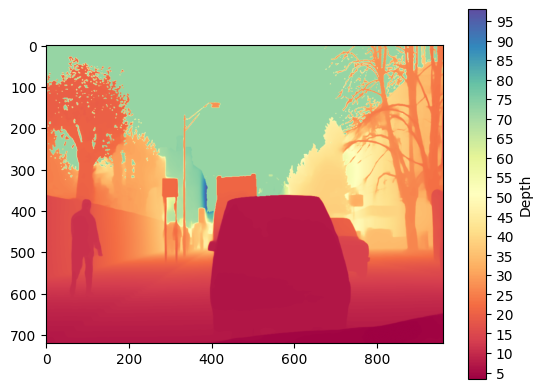

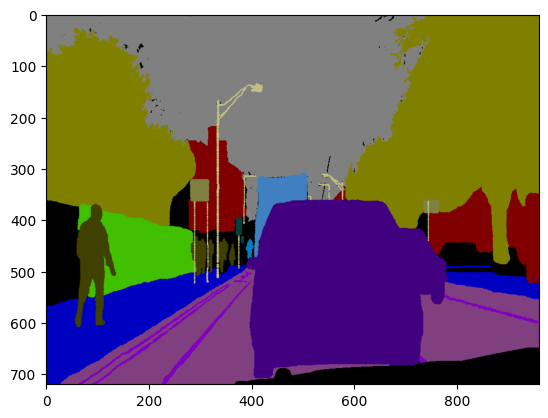

In [7]:
# Create DataModule
data_module = DataModule(
    train_img_dir=TRAIN_IMG_DIR,
    train_depth_dir=TRAIN_DEPTH_DIR,
    train_conf_dir=TRAIN_CONF_DIR,
    train_seg_dir=TRAIN_SEG_DIR,
    val_img_dir=VAL_IMG_DIR,
    val_depth_dir=VAL_DEPTH_DIR,
    val_conf_dir=VAL_CONF_DIR,
    val_seg_dir=VAL_SEG_DIR,
    test_img_dir=TEST_IMG_DIR,
    test_depth_dir=TEST_DEPTH_DIR,
    test_conf_dir=TEST_CONF_DIR,
    test_seg_dir=TEST_SEG_DIR,
    batch_size=4,
    num_workers=2,
    prob=prob
)

# Test it
data_module.setup()
print(f"Training samples: {len(data_module.train_dataset)}")
print(f"Validation samples: {len(data_module.val_dataset)}")
print(f"Test samples: {len(data_module.test_dataset)}")

sample_img, sample_depth, sample_conf, sample_seg = data_module.train_dataset[0]
print(f"\nImage Size: {sample_img.shape}")
print(f"Depth Map Size: {sample_depth.shape}")
print(f"Confidence Map Size: {sample_depth.shape}")
print(f"Segmentation Mask Size: {sample_seg.shape}")

plt.imshow(sample_depth.numpy(), cmap='Spectral')
plt.colorbar(ticks=list(np.arange(0, 100, 5)),label='Depth')
plt.show()

plt.imshow(sample_seg.numpy())
plt.show()

Visualizing predictions on TEST set:


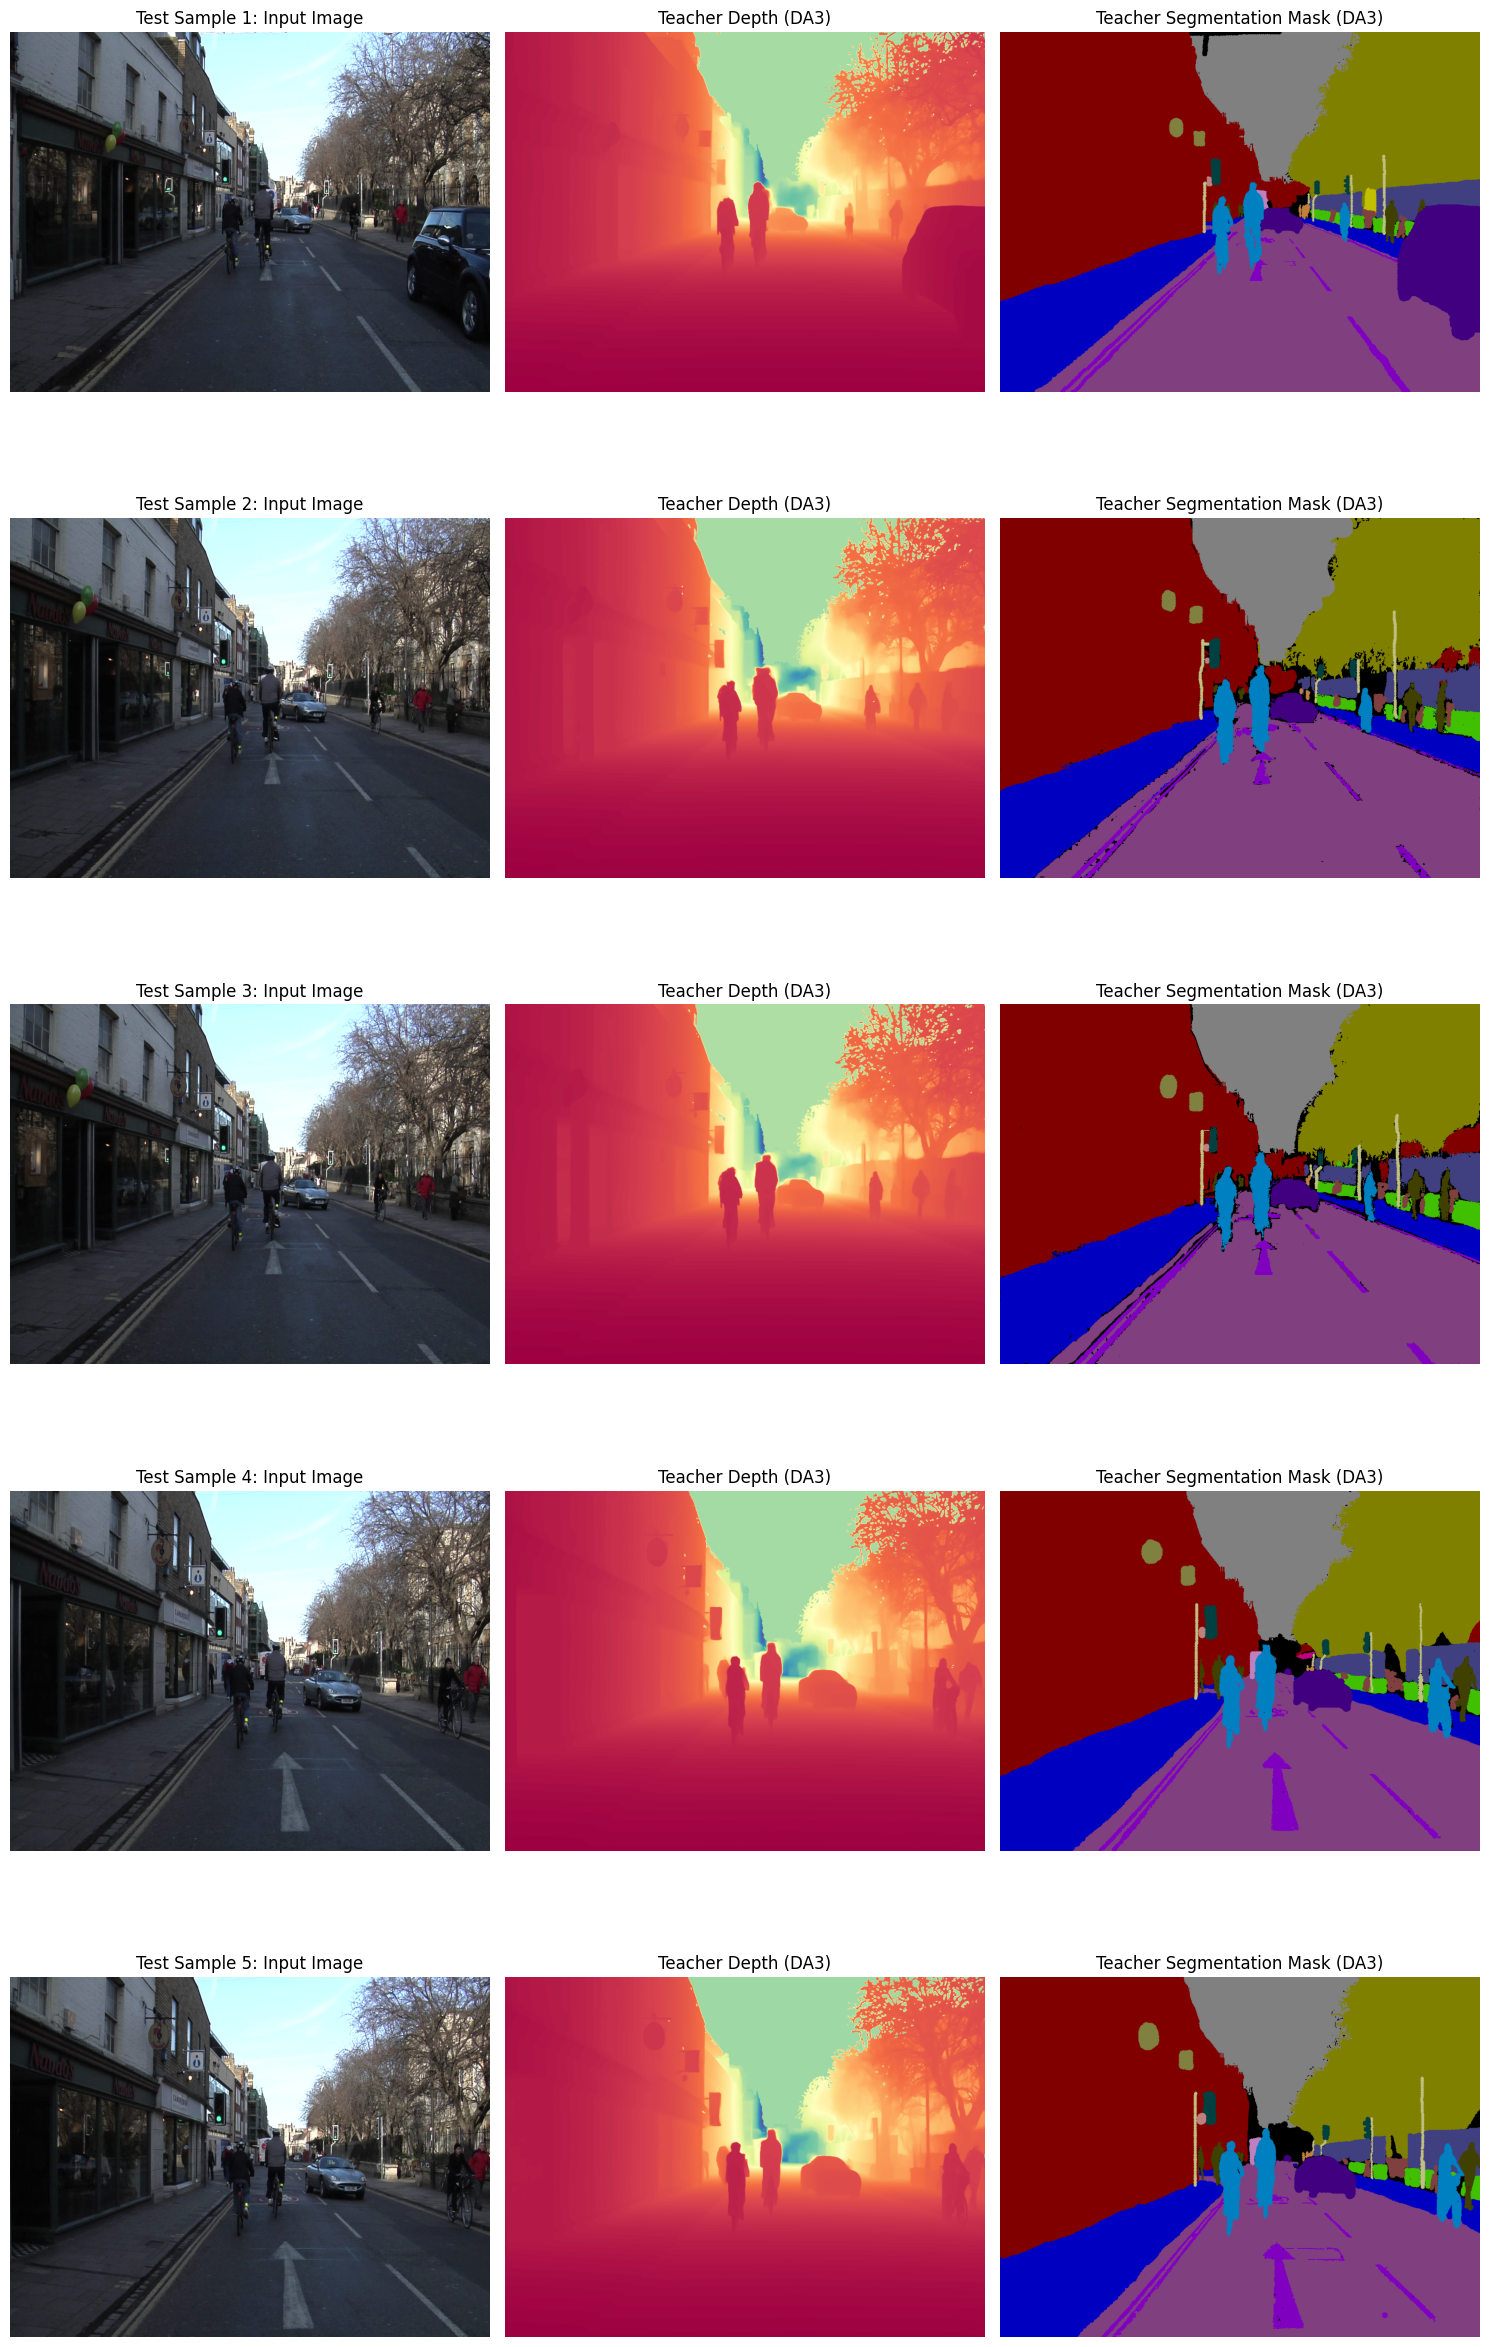

In [8]:
def visualize_predictions(dataset, num_samples=5, seed=42, title_prefix="Test"):
    """Visualize student predictions vs teacher depth maps"""
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples)) # 3

    random.seed(seed)
    offset = random.randrange(0, len(dataset) - num_samples)
    
    with torch.no_grad():
        for i in range(min(num_samples, len(dataset))):
            image, teacher_depth, teacher_conf, teacher_seg = dataset[offset + i]
            
            # Denormalize image for visualization
            img_display = image.clone()
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img_display = img_display * std + mean
            img_display = torch.clamp(img_display, 0, 1)
            
            # Plot
            axes[i, 0].imshow(img_display.permute(1, 2, 0))
            axes[i, 0].set_title(f'{title_prefix} Sample {i+1}: Input Image')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(teacher_depth.numpy(), cmap='Spectral')
            axes[i, 1].set_title('Teacher Depth (DA3)')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(teacher_seg.numpy())
            axes[i, 2].set_title('Teacher Segmentation Mask (DA3)')
            axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'{title_prefix.lower()}_depth_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

print("Visualizing predictions on TEST set:")
visualize_predictions(test_dataset, num_samples=5, title_prefix="Test")

In [9]:
class_labels_df = pd.read_csv("../CamVid/class_dict.csv")

with open('../CamVid/warnable_classes.json', 'r', encoding='utf-8') as f:
    warnable_classes = json.load(f)

In [137]:
def calculate_warnable_classes(img, mask, class_labels_df, warnable_classes_path, alpha=0.5):
    """
    Overlay warnable segmentation classes on an image.
    
    Args:
        img: Input image (numpy array, PIL Image, or torch.Tensor) with shape (C, H, W) or (H, W, C)
        mask: Segmentation mask (numpy array, PIL Image, or torch.Tensor) with shape (C, H, W) or (H, W, C)
        class_labels_df: DataFrame with columns ['name', 'r', 'g', 'b']
        warnable_classes_path: Path to JSON file with warnable classes (0 or 1)
        alpha: Transparency of overlay (0=transparent, 1=opaque)
    
    Returns:
        overlayed_img: Image with warnable classes overlayed
    """
    # Convert torch tensors to numpy arrays
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
        # If channel first (C, H, W), convert to (H, W, C)
        if img.shape[0] == 3 or img.shape[0] == 1:
            img = np.transpose(img, (1, 2, 0))
        # Denormalize if normalized (assuming ImageNet normalization)
        if img.min() < 0 or img.max() <= 1:
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = img * std + mean
            img = (img * 255).clip(0, 255).astype(np.uint8)
    
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()
        # If channel first (C, H, W), convert to (H, W, C)
        if len(mask.shape) == 3 and mask.shape[0] == 3:
            mask = np.transpose(mask, (1, 2, 0))
        # If mask is in [0, 1] range, convert to [0, 255]
        if mask.max() <= 1:
            mask = (mask * 255).astype(np.uint8)
    
    # Convert to numpy arrays if PIL Image
    if isinstance(img, Image.Image):
        img = np.array(img)
    if isinstance(mask, Image.Image):
        mask = np.array(mask)
    
    # Ensure uint8 type
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)
    
    # Load warnable classes
    with open(warnable_classes_path, 'r') as f:
        warnable_classes = json.load(f)
    
    # Create binary mask for warnable classes
    warnable_binary_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=bool)
    
    # Iterate through each warnable class
    for idx, row in class_labels_df.iterrows():
        class_name = row['name']
        
        # Check if this class is warnable
        if warnable_classes.get(class_name, 0) == 1:
            r, g, b = row['r'], row['g'], row['b']
            
            # Find pixels matching this class color
            class_pixels = (mask[:, :, 0] == r) & \
                          (mask[:, :, 1] == g) & \
                          (mask[:, :, 2] == b)
            
            warnable_binary_mask |= class_pixels

    print(mask.shape)
    print(warnable_binary_mask.shape)
    warnable_mask = mask.copy()
    
    warnable_mask[~warnable_binary_mask, :] = 0
    
    plt.imshow(img, cmap='Spectral')
    plt.imshow(warnable_mask + 100, alpha = 0.7)
    plt.axis('off')
    plt.show()
    
    return warnable_mask, warnable_binary_mask

In [ ]:
def overlay_warnable_classes(img, mask, warnable_binary_mask, alpha=0.5):
    """
    Apply alpha blending overlay of mask on image using warnable binary mask.
    
    Args:
        img: Input image (H, W, C) numpy array/tensor, uint8
        mask: Segmentation mask (H, W, C) numpy array/tensor, uint8
        warnable_binary_mask: Binary mask (H, W) boolean array indicating warnable pixels
        alpha: Transparency of overlay (0=transparent, 1=opaque)
    
    Returns:
        overlayed_img: Image with warnable classes overlayed (H, W, C) uint8
    """
    # Convert tensors to numpy if needed
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
        if img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))
        if img.min() < 0 or img.max() <= 1:
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = img * std + mean
            img = (img * 255).clip(0, 255).astype(np.uint8)
    
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()
        if len(mask.shape) == 3 and mask.shape[0] == 3:
            mask = np.transpose(mask, (1, 2, 0))
        if mask.max() <= 1:
            mask = (mask * 255).astype(np.uint8)
    
    # Create a copy of the image to overlay on
    overlayed_img = img.copy().astype(float)
    
    # Apply alpha blending only where warnable_binary_mask is True
    overlayed_img[warnable_binary_mask] = (1 - alpha) * img[warnable_binary_mask] + \
                                           alpha * mask[warnable_binary_mask]
    
    return overlayed_img.astype(np.uint8)

(720, 960, 3)
(720, 960)


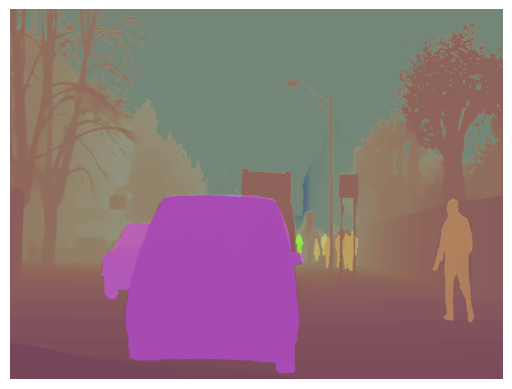

In [138]:
warnable_mask, warnable_binary_mask = calculate_warnable_classes(
    sample_depth, 
    sample_seg, 
    class_labels_df, 
    warnable_classes_path = '../CamVid/warnable_classes.json', 
    alpha=0.5
)

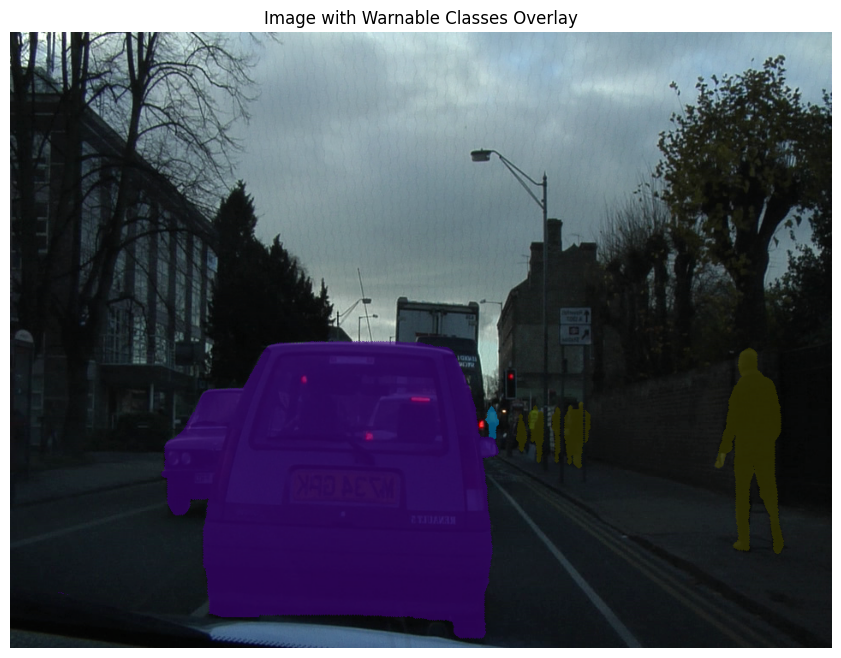

In [153]:
overlayed_img = overlay_warnable_classes(
    img=sample_img,  # Debe ser numpy array (H, W, C) uint8
    mask=sample_seg,  # Debe ser numpy array (H, W, C) uint8  
    warnable_binary_mask=warnable_binary_mask,
    alpha=0.6
)

# Display
plt.figure(figsize=(12, 8))
plt.imshow(overlayed_img)
plt.title('Image with Warnable Classes Overlay')
plt.axis('off')
plt.show()

In [154]:
sample_depth 

tensor([[23.6722, 23.5770, 23.8290,  ..., 72.5140, 72.5140, 72.5140],
        [23.6976, 23.6957, 23.7649,  ..., 72.5140, 72.5140, 72.5140],
        [23.7847, 23.7102, 23.7564,  ..., 72.5140, 72.5140, 72.5140],
        ...,
        [ 4.2641,  4.2504,  4.1061,  ...,  6.8352,  6.8285,  6.8480],
        [ 4.1439,  4.2896,  4.1085,  ...,  6.8261,  6.8155,  6.8405],
        [ 4.3811,  4.3051,  4.3641,  ...,  6.8104,  6.8180,  6.8404]])

# V2

In [162]:
def calculate_warnable_classes_v2(img, mask, class_labels_df, warnable_classes_path, 
                                   alpha=0.5, min_area=100, visualize=True):
    """
    Overlay warnable segmentation classes on an image and segment individual objects.
    
    Args:
        img: Input image (numpy array, PIL Image, or torch.Tensor) with shape (C, H, W) or (H, W, C)
        mask: Segmentation mask (numpy array, PIL Image, or torch.Tensor) with shape (C, H, W) or (H, W, C)
        class_labels_df: DataFrame with columns ['name', 'r', 'g', 'b']
        warnable_classes_path: Path to JSON file with warnable classes (0 or 1)
        alpha: Transparency of overlay (0=transparent, 1=opaque)
        min_area: Minimum area (in pixels) to consider an object valid
        visualize: Whether to show visualization
    
    Returns:
        warnable_mask: Image with warnable classes overlayed
        warnable_binary_mask: Binary mask of warnable areas
        segmented_objects: List of dictionaries with object properties
        labels_map: Labeled image with unique ID for each object
    """
    from skimage.measure import label, regionprops
    
    # Convert torch tensors to numpy arrays
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
        if img.shape[0] == 3 or img.shape[0] == 1:
            img = np.transpose(img, (1, 2, 0))
        if img.min() < 0 or img.max() <= 1:
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = img * std + mean
            img = (img * 255).clip(0, 255).astype(np.uint8)
    
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()
        if len(mask.shape) == 3 and mask.shape[0] == 3:
            mask = np.transpose(mask, (1, 2, 0))
        if mask.max() <= 1:
            mask = (mask * 255).astype(np.uint8)
    
    # Convert to numpy arrays if PIL Image
    if isinstance(img, Image.Image):
        img = np.array(img)
    if isinstance(mask, Image.Image):
        mask = np.array(mask)
    
    # Ensure uint8 type
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)
    
    # Load warnable classes
    with open(warnable_classes_path, 'r') as f:
        warnable_classes = json.load(f)
    
    # Create binary mask for warnable classes
    warnable_binary_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=bool)
    
    # Dictionary to store class information for each pixel
    class_map = np.zeros((mask.shape[0], mask.shape[1]), dtype=int)
    class_id_mapping = {}
    
    # Iterate through each warnable class
    current_class_id = 1
    for idx, row in class_labels_df.iterrows():
        class_name = row['name']
        
        # Check if this class is warnable
        if warnable_classes.get(class_name, 0) == 1:
            r, g, b = row['r'], row['g'], row['b']
            
            # Find pixels matching this class color
            class_pixels = (mask[:, :, 0] == r) & \
                          (mask[:, :, 1] == g) & \
                          (mask[:, :, 2] == b)
            
            warnable_binary_mask |= class_pixels
            class_map[class_pixels] = current_class_id
            class_id_mapping[current_class_id] = {
                'name': class_name,
                'color': (r, g, b)
            }
            current_class_id += 1
    
    # Segment connected components
    labels_map = label(warnable_binary_mask.astype(np.uint8), connectivity=2)
    props = regionprops(labels_map)
    
    # Extract object information
    segmented_objects = []
    valid_labels = []
    
    for prop in props:
        # Filter by minimum area
        if prop.area < min_area:
            continue
            
        # Get the class of this object (most common class in the region)
        object_mask = labels_map == prop.label
        object_classes = class_map[object_mask]
        most_common_class = np.bincount(object_classes[object_classes > 0]).argmax()
        
        obj_info = {
            'label': prop.label,
            'class_id': most_common_class,
            'class_name': class_id_mapping[most_common_class]['name'],
            'class_color': class_id_mapping[most_common_class]['color'],
            'area': prop.area,
            'centroid': prop.centroid,
            'bbox': prop.bbox,  # (min_row, min_col, max_row, max_col)
            'perimeter': prop.perimeter,
            'eccentricity': prop.eccentricity,
            'orientation': prop.orientation,
            'mask': object_mask
        }
        
        segmented_objects.append(obj_info)
        valid_labels.append(prop.label)
    
    print(f"Found {len(segmented_objects)} warnable objects (min_area={min_area})")
    
    # Create warnable mask
    warnable_mask = mask.copy()
    warnable_mask[~warnable_binary_mask, :] = 0
    
    # Visualization
    if visualize:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Original image with overlay
        axes[0].imshow(img)
        axes[0].imshow(warnable_mask, alpha=alpha)
        axes[0].set_title('Warnable Classes Overlay')
        axes[0].axis('off')
        
        # Segmented objects with labels
        axes[1].imshow(img)
        colored_labels = np.zeros_like(img)
        for obj in segmented_objects:
            colored_labels[obj['mask']] = obj['class_color']
        axes[1].imshow(colored_labels, alpha=alpha)
        
        # Add centroids and bounding boxes
        for i, obj in enumerate(segmented_objects):
            y, x = obj['centroid']
            axes[1].plot(x, y, 'r*', markersize=10)
            axes[1].text(x, y, str(i+1), color='white', fontsize=12, 
                        ha='center', va='center', weight='bold',
                        bbox=dict(boxstyle='round', facecolor='red', alpha=0.7))
            
            min_row, min_col, max_row, max_col = obj['bbox']
            rect = plt.Rectangle((min_col, min_row), max_col-min_col, max_row-min_row,
                                fill=False, edgecolor='yellow', linewidth=2)
            axes[1].add_patch(rect)
        
        axes[1].set_title(f'Segmented Objects ({len(segmented_objects)})')
        axes[1].axis('off')
        
        # Labels map
        axes[2].imshow(labels_map, cmap='nipy_spectral')
        axes[2].set_title('Component Labels')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Print detailed information
    for i, obj in enumerate(segmented_objects):
        print(f"\nObject {i+1}:")
        print(f"  Class: {obj['class_name']}")
        print(f"  Area: {obj['area']} pixels")
        print(f"  Centroid: ({obj['centroid'][0]:.1f}, {obj['centroid'][1]:.1f})")
        print(f"  Bounding box: {obj['bbox']}")
        print(f"  Perimeter: {obj['perimeter']:.1f}")
        print(f"  Eccentricity: {obj['eccentricity']:.3f}")
    
    return warnable_mask, warnable_binary_mask, segmented_objects, labels_map


# Función auxiliar para extraer un objeto específico
def extract_object(img, segmented_objects, object_idx):
    """
    Extract a specific object from the image.
    
    Args:
        img: Original image
        segmented_objects: List of objects from calculate_warnable_classes_v2
        object_idx: Index of object to extract (0-based)
    
    Returns:
        cropped_img: Cropped image containing only the object
        object_mask: Binary mask of the object in cropped coordinates
    """
    obj = segmented_objects[object_idx]
    min_row, min_col, max_row, max_col = obj['bbox']
    
    # Crop image
    cropped_img = img[min_row:max_row, min_col:max_col].copy()
    
    # Crop and adjust mask
    full_mask = obj['mask']
    cropped_mask = full_mask[min_row:max_row, min_col:max_col]
    
    return cropped_img, cropped_mask

Found 7 warnable objects (min_area=100)


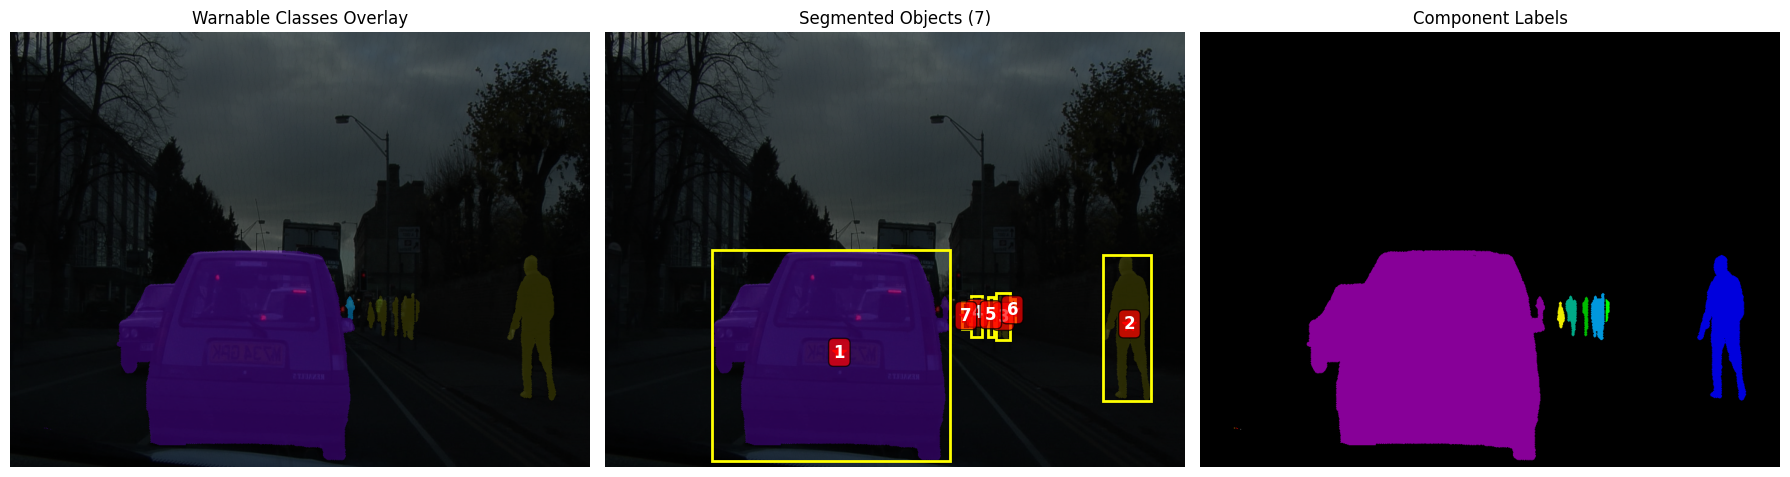


Object 1:
  Class: Car
  Area: 105965.0 pixels
  Centroid: (529.8, 387.4)
  Bounding box: (361, 176, 709, 571)
  Perimeter: 1778.6
  Eccentricity: 0.454

Object 2:
  Class: Pedestrian
  Area: 9970.0 pixels
  Centroid: (482.7, 867.6)
  Bounding box: (369, 823, 610, 904)
  Perimeter: 984.8
  Eccentricity: 0.954

Object 3:
  Class: Pedestrian
  Area: 1357.0 pixels
  Centroid: (470.2, 658.7)
  Bounding box: (432, 647, 510, 670)
  Perimeter: 245.4
  Eccentricity: 0.950

Object 4:
  Class: Pedestrian
  Area: 774.0 pixels
  Centroid: (464.9, 615.0)
  Bounding box: (436, 605, 504, 624)
  Perimeter: 176.6
  Eccentricity: 0.962

Object 5:
  Class: Pedestrian
  Area: 431.0 pixels
  Centroid: (467.5, 638.1)
  Bounding box: (438, 633, 504, 643)
  Perimeter: 165.6
  Eccentricity: 0.991

Object 6:
  Class: Pedestrian
  Area: 184.0 pixels
  Centroid: (459.2, 673.7)
  Bounding box: (442, 671, 480, 678)
  Perimeter: 92.2
  Eccentricity: 0.985

Object 7:
  Class: Pedestrian
  Area: 353.0 pixels
  Centro

In [164]:
warnable_classes_path = '../CamVid/warnable_classes.json'

warnable_mask, binary_mask, objects, labels = calculate_warnable_classes_v2(
    sample_img, sample_seg, class_labels_df, warnable_classes_path, 
    alpha=0.6, min_area=100
)

# Acceder a un objeto específico
obj = objects[0]
print(f"Primer objeto: {obj['class_name']}, área: {obj['area']}")

# Extraer una región específica
cropped, mask = extract_object(img, objects, 0)

# V3

In [174]:
def filter_objects_by_depth(segmented_objects, img_depth, depth_threshold=4.5, visualize=True):
    """
    Filter objects based on their average depth.
    
    Args:
        segmented_objects: List of objects from calculate_warnable_classes_v2
        img_depth: Depth map (numpy array or torch.Tensor) with same H, W as mask
                   Each value represents depth in meters
        depth_threshold: Maximum average depth to keep object (default: 4.5 meters)
        visualize: Whether to show visualization
    
    Returns:
        filtered_objects: List of objects with avg_depth < depth_threshold
        rejected_objects: List of objects with avg_depth >= depth_threshold
        depth_stats: Dictionary with depth statistics for all objects
    """
    # Convert torch tensor to numpy if needed
    if isinstance(img_depth, torch.Tensor):
        img_depth = img_depth.cpu().numpy()
        # If channel first (1, H, W), convert to (H, W)
        if len(img_depth.shape) == 3 and img_depth.shape[0] == 1:
            img_depth = img_depth.squeeze(0)
    
    filtered_objects = []
    rejected_objects = []
    depth_stats = {
        'all_depths': [],
        'filtered_depths': [],
        'rejected_depths': []
    }
    
    print(f"\nFiltering objects by depth (threshold: {depth_threshold}m)")
    print("=" * 60)
    
    for i, obj in enumerate(segmented_objects):
        # Get depth values for this object's mask
        object_depths = img_depth[obj['mask']]
        
        # Remove invalid depths (NaN, inf, negative)
        valid_depths = object_depths[np.isfinite(object_depths) & (object_depths >= 0)]
        
        if len(valid_depths) == 0:
            print(f"Object {i+1} ({obj['class_name']}): No valid depth data - REJECTED")
            rejected_objects.append(obj)
            continue
        
        # Calculate statistics
        avg_depth = np.mean(valid_depths)
        min_depth = np.min(valid_depths)
        max_depth = np.max(valid_depths)
        std_depth = np.std(valid_depths)
        median_depth = np.median(valid_depths)
        
        # Add depth info to object
        obj_with_depth = obj.copy()
        obj_with_depth['avg_depth'] = avg_depth
        obj_with_depth['min_depth'] = min_depth
        obj_with_depth['max_depth'] = max_depth
        obj_with_depth['std_depth'] = std_depth
        obj_with_depth['median_depth'] = median_depth
        
        depth_stats['all_depths'].append(avg_depth)
        
        # Filter by threshold
        if avg_depth < depth_threshold:
            filtered_objects.append(obj_with_depth)
            depth_stats['filtered_depths'].append(avg_depth)
            status = "✓ KEPT"
        else:
            rejected_objects.append(obj_with_depth)
            depth_stats['rejected_depths'].append(avg_depth)
            status = "✗ REJECTED"
        
        print(f"Object {i+1} ({obj['class_name']}): {status}")
        print(f"  Avg depth: {avg_depth:.2f}m | Min: {min_depth:.2f}m | Max: {max_depth:.2f}m | Std: {std_depth:.2f}m")
    
    print("=" * 60)
    print(f"Results: {len(filtered_objects)} kept, {len(rejected_objects)} rejected")
    
    # Visualization
    if visualize and len(segmented_objects) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Depth map
        im0 = axes[0, 0].imshow(img_depth, cmap='viridis')
        axes[0, 0].set_title('Depth Map (meters)')
        axes[0, 0].axis('off')
        plt.colorbar(im0, ax=axes[0, 0])
        
        # 2. All objects with depth values
        axes[0, 1].imshow(img_depth, cmap='viridis', alpha=0.5)
        for i, obj in enumerate(segmented_objects):
            if 'avg_depth' in obj:
                y, x = obj['centroid']
                color = 'green' if obj['avg_depth'] < depth_threshold else 'red'
                axes[0, 1].plot(x, y, '*', color=color, markersize=15)
                axes[0, 1].text(x, y+20, f"{obj['avg_depth']:.1f}m", 
                              color=color, fontsize=10, ha='center', weight='bold',
                              bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        axes[0, 1].set_title(f'All Objects (Green: <{depth_threshold}m, Red: ≥{depth_threshold}m)')
        axes[0, 1].axis('off')
        
        # 3. Filtered objects only
        filtered_mask = np.zeros_like(img_depth, dtype=bool)
        for obj in filtered_objects:
            filtered_mask |= obj['mask']
        
        axes[1, 0].imshow(img_depth, cmap='viridis', alpha=0.3)
        axes[1, 0].imshow(filtered_mask, cmap='Greens', alpha=0.5)
        for i, obj in enumerate(filtered_objects):
            y, x = obj['centroid']
            axes[1, 0].plot(x, y, 'g*', markersize=15)
            axes[1, 0].text(x, y, str(i+1), color='white', fontsize=12, 
                          ha='center', va='center', weight='bold',
                          bbox=dict(boxstyle='round', facecolor='green', alpha=0.7))
        axes[1, 0].set_title(f'Filtered Objects (<{depth_threshold}m): {len(filtered_objects)}')
        axes[1, 0].axis('off')
        
        # 4. Histogram of depths
        if depth_stats['all_depths']:
            axes[1, 1].hist(depth_stats['all_depths'], bins=20, alpha=0.5, label='All', color='gray')
            if depth_stats['filtered_depths']:
                axes[1, 1].hist(depth_stats['filtered_depths'], bins=20, alpha=0.7, label='Kept', color='green')
            if depth_stats['rejected_depths']:
                axes[1, 1].hist(depth_stats['rejected_depths'], bins=20, alpha=0.7, label='Rejected', color='red')
            axes[1, 1].axvline(depth_threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold ({depth_threshold}m)')
            axes[1, 1].set_xlabel('Average Depth (meters)')
            axes[1, 1].set_ylabel('Number of Objects')
            axes[1, 1].set_title('Depth Distribution')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return filtered_objects, rejected_objects, depth_stats


def extract_filtered_objects_with_depth(img, img_depth, filtered_objects):
    """
    Extract cropped images and depth maps for filtered objects.
    
    Args:
        img: Original RGB image (numpy array or torch.Tensor)
        img_depth: Depth map (numpy array or torch.Tensor)
        filtered_objects: List of filtered objects
    
    Returns:
        extractions: List of dictionaries with cropped data
    """
    # Convert torch tensors to numpy arrays
    if isinstance(img, torch.Tensor):
        img_np = img.cpu().numpy()
        # If channel first (C, H, W), convert to (H, W, C)
        if img_np.shape[0] == 3 or img_np.shape[0] == 1:
            img_np = np.transpose(img_np, (1, 2, 0))
        # Denormalize if normalized
        if img_np.min() < 0 or img_np.max() <= 1:
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_np = img_np * std + mean
            img_np = (img_np * 255).clip(0, 255).astype(np.uint8)
    else:
        img_np = img
    
    if isinstance(img_depth, torch.Tensor):
        depth_np = img_depth.cpu().numpy()
        # If channel first (1, H, W), convert to (H, W)
        if len(depth_np.shape) == 3 and depth_np.shape[0] == 1:
            depth_np = depth_np.squeeze(0)
    else:
        depth_np = img_depth
    
    extractions = []
    
    for i, obj in enumerate(filtered_objects):
        min_row, min_col, max_row, max_col = obj['bbox']
        
        # Crop RGB image
        cropped_img = img_np[min_row:max_row, min_col:max_col].copy()
        
        # Crop depth map
        cropped_depth = depth_np[min_row:max_row, min_col:max_col].copy()
        
        # Crop mask
        full_mask = obj['mask']
        cropped_mask = full_mask[min_row:max_row, min_col:max_col]
        
        # Apply mask to get only the object
        masked_img = cropped_img.copy()
        masked_img[~cropped_mask] = 0
        
        masked_depth = cropped_depth.copy()
        masked_depth[~cropped_mask] = np.nan
        
        extraction = {
            'object_id': i,
            'class_name': obj['class_name'],
            'avg_depth': obj['avg_depth'],
            'min_depth': obj['min_depth'],
            'max_depth': obj['max_depth'],
            'std_depth': obj['std_depth'],
            'median_depth': obj['median_depth'],
            'cropped_img': cropped_img,
            'cropped_depth': cropped_depth,
            'cropped_mask': cropped_mask,
            'masked_img': masked_img,
            'masked_depth': masked_depth,
            'bbox': obj['bbox'],
            'centroid': obj['centroid'],
            'area': obj['area']
        }
        
        extractions.append(extraction)
    
    return extractions


# Función auxiliar para visualizar extracciones
def visualize_extractions(extractions, max_cols=4):
    """
    Visualize all extracted objects in a grid.
    
    Args:
        extractions: List from extract_filtered_objects_with_depth
        max_cols: Maximum columns in grid
    """
    if len(extractions) == 0:
        print("No objects to visualize")
        return
    
    n_objects = len(extractions)
    n_cols = min(max_cols, n_objects)
    n_rows = (n_objects + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols * 3, figsize=(5*n_cols, 5*n_rows))
    
    # Ensure axes is 2D
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes[0], axes[1], axes[2]]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, ext in enumerate(extractions):
        row = idx // n_cols
        col = idx % n_cols
        
        # RGB masked
        ax_rgb = axes[row, col*3] if n_rows > 1 or n_cols > 1 else axes[0, col*3]
        ax_rgb.imshow(ext['masked_img'])
        ax_rgb.set_title(f"Obj {ext['object_id']+1}: {ext['class_name']}\n"
                        f"Depth: {ext['avg_depth']:.2f}m", fontsize=10)
        ax_rgb.axis('off')
        
        # Depth masked
        ax_depth = axes[row, col*3+1] if n_rows > 1 or n_cols > 1 else axes[0, col*3+1]
        im = ax_depth.imshow(ext['masked_depth'], cmap='viridis')
        ax_depth.set_title(f"Min: {ext['min_depth']:.2f}m\n"
                          f"Max: {ext['max_depth']:.2f}m", fontsize=9)
        ax_depth.axis('off')
        plt.colorbar(im, ax=ax_depth, fraction=0.046)
        
        # Mask
        ax_mask = axes[row, col*3+2] if n_rows > 1 or n_cols > 1 else axes[0, col*3+2]
        ax_mask.imshow(ext['cropped_mask'], cmap='gray')
        ax_mask.set_title(f"Area: {ext['area']} px", fontsize=10)
        ax_mask.axis('off')
    
    # Hide unused subplots
    for idx in range(n_objects, n_rows * n_cols):
        row = idx // n_cols
        for offset in range(3):
            col = idx % n_cols
            ax = axes[row, col*3+offset] if n_rows > 1 or n_cols > 1 else axes[0, col*3+offset]
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

Found 7 warnable objects (min_area=100)


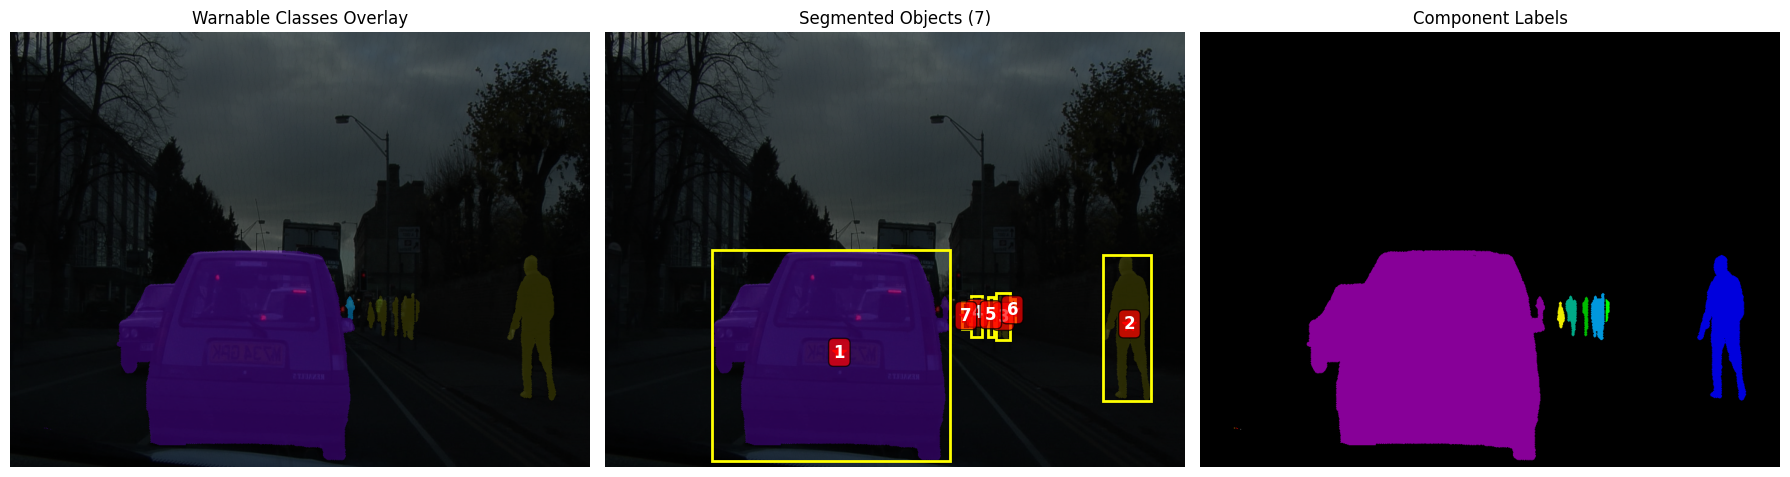


Object 1:
  Class: Car
  Area: 105965.0 pixels
  Centroid: (529.8, 387.4)
  Bounding box: (361, 176, 709, 571)
  Perimeter: 1778.6
  Eccentricity: 0.454

Object 2:
  Class: Pedestrian
  Area: 9970.0 pixels
  Centroid: (482.7, 867.6)
  Bounding box: (369, 823, 610, 904)
  Perimeter: 984.8
  Eccentricity: 0.954

Object 3:
  Class: Pedestrian
  Area: 1357.0 pixels
  Centroid: (470.2, 658.7)
  Bounding box: (432, 647, 510, 670)
  Perimeter: 245.4
  Eccentricity: 0.950

Object 4:
  Class: Pedestrian
  Area: 774.0 pixels
  Centroid: (464.9, 615.0)
  Bounding box: (436, 605, 504, 624)
  Perimeter: 176.6
  Eccentricity: 0.962

Object 5:
  Class: Pedestrian
  Area: 431.0 pixels
  Centroid: (467.5, 638.1)
  Bounding box: (438, 633, 504, 643)
  Perimeter: 165.6
  Eccentricity: 0.991

Object 6:
  Class: Pedestrian
  Area: 184.0 pixels
  Centroid: (459.2, 673.7)
  Bounding box: (442, 671, 480, 678)
  Perimeter: 92.2
  Eccentricity: 0.985

Object 7:
  Class: Pedestrian
  Area: 353.0 pixels
  Centro

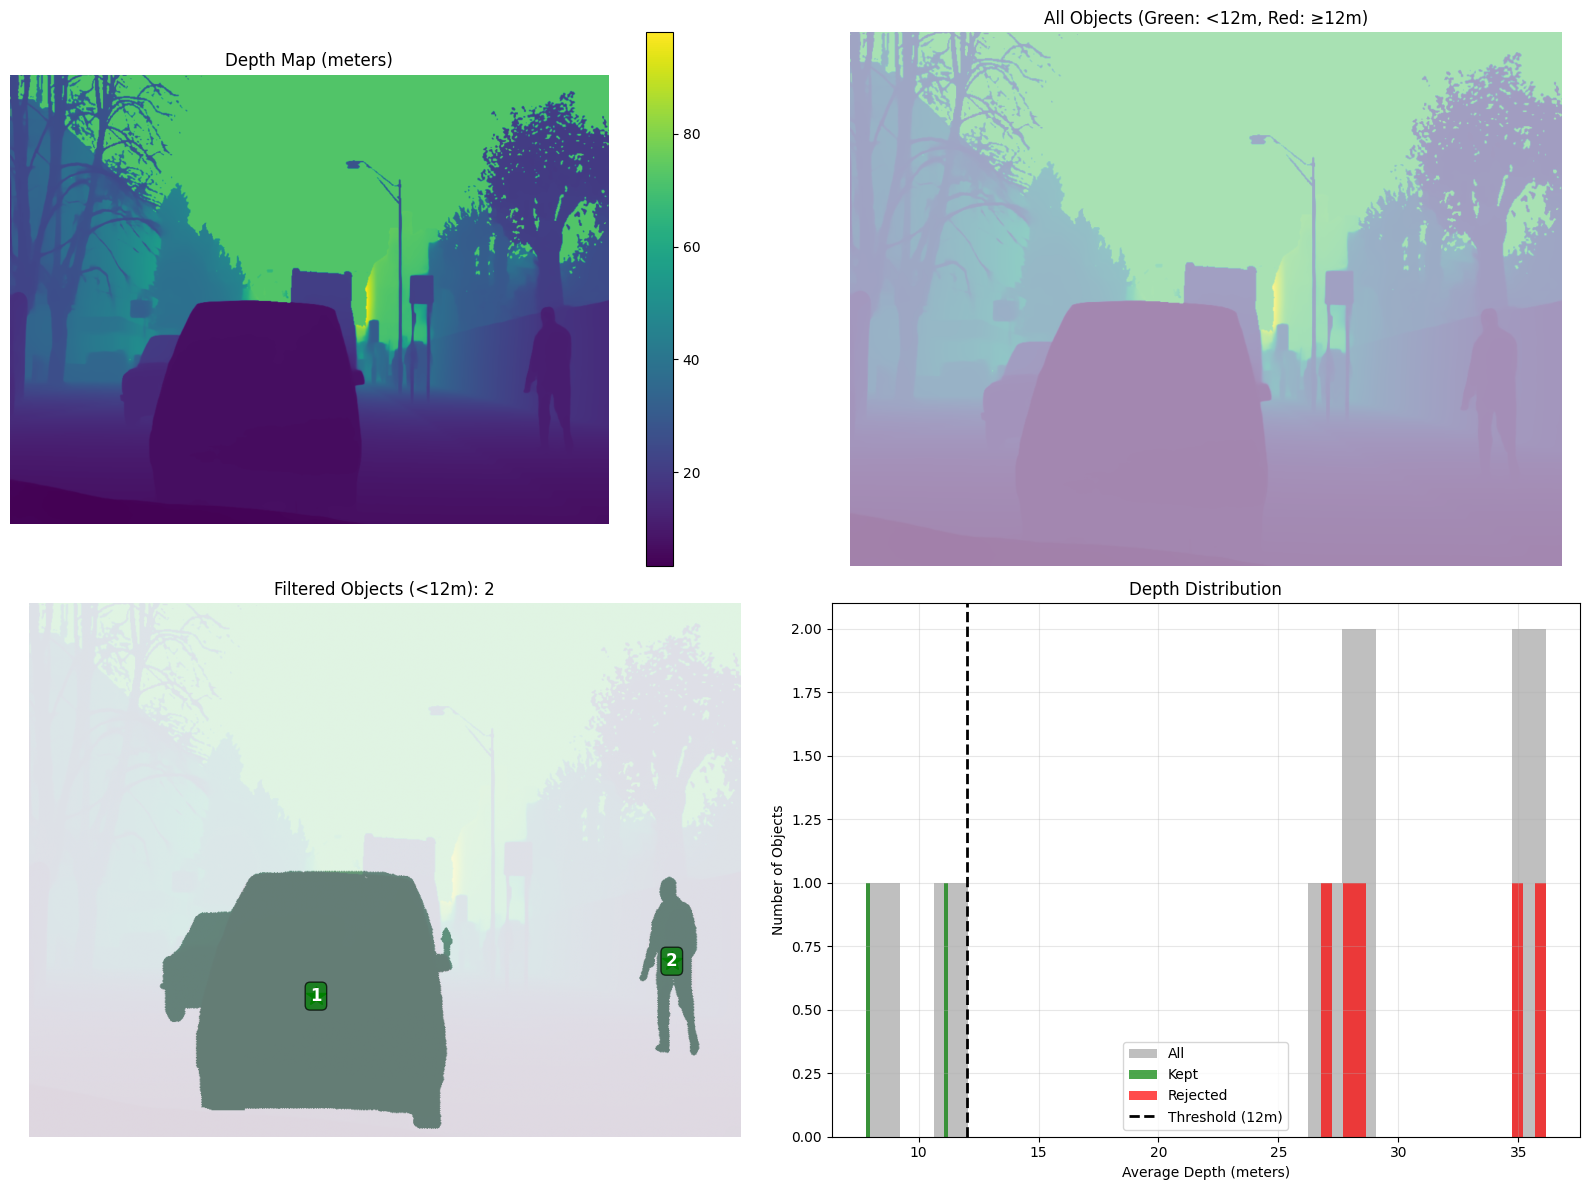


Objeto 0 - Car
Profundidad media: 7.79m
Área: 105965.0 pixels


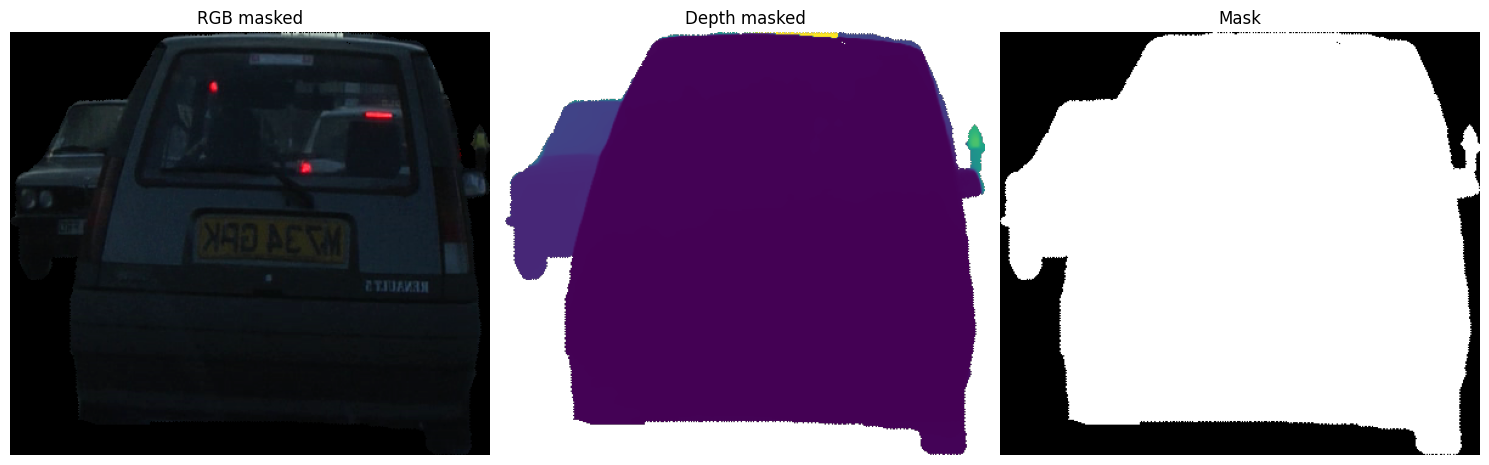


Objeto 1 - Pedestrian
Profundidad media: 11.22m
Área: 9970.0 pixels


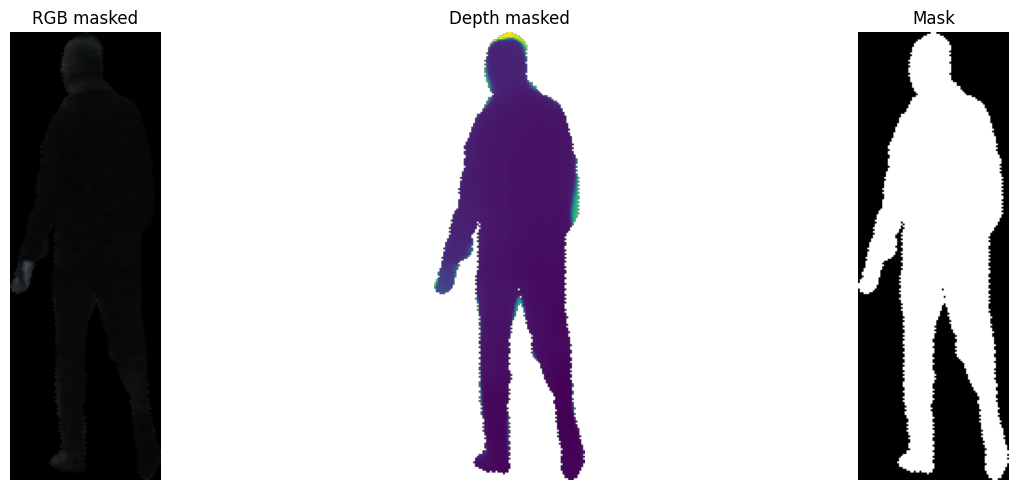

In [176]:
# 1. Segmentar objetos warnable
warnable_mask, binary_mask, objects, labels = calculate_warnable_classes_v2(
    sample_img, sample_seg, class_labels_df, warnable_classes_path, 
    alpha=0.6, min_area=100
)

# 2. Filtrar por profundidad
filtered_objects, rejected_objects, depth_stats = filter_objects_by_depth(
    objects, sample_depth, depth_threshold=12, visualize=True
)

# 3. Extraer los objetos filtrados con sus crops
extractions = extract_filtered_objects_with_depth(sample_img, sample_depth, filtered_objects)

# 4. Trabajar con cada objeto
for ext in extractions:
    print(f"\nObjeto {ext['object_id']} - {ext['class_name']}")
    print(f"Profundidad media: {ext['avg_depth']:.2f}m")
    print(f"Área: {ext['area']} pixels")
    
    # Visualizar
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(ext['masked_img'])
    axes[0].set_title('RGB masked')
    axes[0].axis('off')
    
    axes[1].imshow(ext['masked_depth'], cmap='viridis')
    axes[1].set_title('Depth masked')
    axes[1].axis('off')
    
    axes[2].imshow(ext['cropped_mask'], cmap='gray')
    axes[2].set_title('Mask')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# V4

In [10]:
def calculate_warnable_classes_v2(img, mask, class_labels_df, warnable_classes_path, 
                                   alpha=0.5, min_area=100, visualize=True):
    """
    Overlay warnable segmentation classes on an image and segment individual objects.
    
    Args:
        img: Input image (numpy array, PIL Image, or torch.Tensor) with shape (C, H, W) or (H, W, C)
        mask: Segmentation mask (numpy array, PIL Image, or torch.Tensor) with shape (C, H, W) or (H, W, C)
        class_labels_df: DataFrame with columns ['name', 'r', 'g', 'b']
        warnable_classes_path: Path to JSON file with warnable classes (0 or 1)
        alpha: Transparency of overlay (0=transparent, 1=opaque)
        min_area: Minimum area (in pixels) to consider an object valid
        visualize: Whether to show visualization
    
    Returns:
        warnable_mask: Image with warnable classes overlayed
        warnable_binary_mask: Binary mask of warnable areas
        segmented_objects: List of dictionaries with object properties
        labels_map: Labeled image with unique ID for each object
    """
    from skimage.measure import label, regionprops
    
    # Convert torch tensors to numpy arrays
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
        if img.shape[0] == 3 or img.shape[0] == 1:
            img = np.transpose(img, (1, 2, 0))
        if img.min() < 0 or img.max() <= 1:
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = img * std + mean
            img = (img * 255).clip(0, 255).astype(np.uint8)
    
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()
        if len(mask.shape) == 3 and mask.shape[0] == 3:
            mask = np.transpose(mask, (1, 2, 0))
        if mask.max() <= 1:
            mask = (mask * 255).astype(np.uint8)
    
    # Convert to numpy arrays if PIL Image
    if isinstance(img, Image.Image):
        img = np.array(img)
    if isinstance(mask, Image.Image):
        mask = np.array(mask)
    
    # Ensure uint8 type
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)
    
    # Load warnable classes
    with open(warnable_classes_path, 'r') as f:
        warnable_classes = json.load(f)
    
    # Create binary mask for warnable classes
    warnable_binary_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=bool)
    
    # Dictionary to store class information for each pixel
    class_map = np.zeros((mask.shape[0], mask.shape[1]), dtype=int)
    class_id_mapping = {}
    
    # Iterate through each warnable class
    current_class_id = 1
    for idx, row in class_labels_df.iterrows():
        class_name = row['name']
        
        # Check if this class is warnable
        if warnable_classes.get(class_name, 0) == 1:
            r, g, b = row['r'], row['g'], row['b']
            
            # Find pixels matching this class color
            class_pixels = (mask[:, :, 0] == r) & \
                          (mask[:, :, 1] == g) & \
                          (mask[:, :, 2] == b)
            
            warnable_binary_mask |= class_pixels
            class_map[class_pixels] = current_class_id
            class_id_mapping[current_class_id] = {
                'name': class_name,
                'color': (r, g, b)
            }
            current_class_id += 1
    
    # Segment connected components
    labels_map = label(warnable_binary_mask.astype(np.uint8), connectivity=2)
    props = regionprops(labels_map)
    
    # Extract object information
    segmented_objects = []
    valid_labels = []
    
    for prop in props:
        # Filter by minimum area
        if prop.area < min_area:
            continue
            
        # Get the class of this object (most common class in the region)
        object_mask = labels_map == prop.label
        object_classes = class_map[object_mask]
        most_common_class = np.bincount(object_classes[object_classes > 0]).argmax()
        
        obj_info = {
            'label': prop.label,
            'class_id': most_common_class,
            'class_name': class_id_mapping[most_common_class]['name'],
            'class_color': class_id_mapping[most_common_class]['color'],
            'area': prop.area,
            'centroid': prop.centroid,
            'bbox': prop.bbox,  # (min_row, min_col, max_row, max_col)
            'perimeter': prop.perimeter,
            'eccentricity': prop.eccentricity,
            'orientation': prop.orientation,
            'mask': object_mask
        }
        
        segmented_objects.append(obj_info)
        valid_labels.append(prop.label)
    
    print(f"Found {len(segmented_objects)} warnable objects (min_area={min_area})")
    
    # Create warnable mask
    warnable_mask = mask.copy()
    warnable_mask[~warnable_binary_mask, :] = 0
    
    # Visualization
    if visualize:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Original image with overlay
        axes[0].imshow(img)
        axes[0].imshow(warnable_mask, alpha=alpha)
        axes[0].set_title('Warnable Classes Overlay')
        axes[0].axis('off')
        
        # Segmented objects with labels
        axes[1].imshow(img)
        colored_labels = np.zeros_like(img)
        for obj in segmented_objects:
            colored_labels[obj['mask']] = obj['class_color']
        axes[1].imshow(colored_labels, alpha=alpha)
        
        # Add centroids and bounding boxes
        for i, obj in enumerate(segmented_objects):
            y, x = obj['centroid']
            axes[1].plot(x, y, 'r*', markersize=10)
            axes[1].text(x, y, str(i+1), color='white', fontsize=12, 
                        ha='center', va='center', weight='bold',
                        bbox=dict(boxstyle='round', facecolor='red', alpha=0.7))
            
            min_row, min_col, max_row, max_col = obj['bbox']
            rect = plt.Rectangle((min_col, min_row), max_col-min_col, max_row-min_row,
                                fill=False, edgecolor='yellow', linewidth=2)
            axes[1].add_patch(rect)
        
        axes[1].set_title(f'Segmented Objects ({len(segmented_objects)})')
        axes[1].axis('off')
        
        # Labels map
        axes[2].imshow(labels_map, cmap='nipy_spectral')
        axes[2].set_title('Component Labels')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Print detailed information
    for i, obj in enumerate(segmented_objects):
        print(f"\nObject {i+1}:")
        print(f"  Class: {obj['class_name']}")
        print(f"  Area: {obj['area']} pixels")
        print(f"  Centroid: ({obj['centroid'][0]:.1f}, {obj['centroid'][1]:.1f})")
        print(f"  Bounding box: {obj['bbox']}")
        print(f"  Perimeter: {obj['perimeter']:.1f}")
        print(f"  Eccentricity: {obj['eccentricity']:.3f}")
    
    return warnable_mask, warnable_binary_mask, segmented_objects, labels_map

In [11]:
def filter_objects_by_depth(segmented_objects, img_depth, depth_threshold=4.5, 
                           outlier_method='iqr', outlier_factor=1.5, 
                           min_valid_ratio=0.3, visualize=True):
    """
    Filter objects based on their average depth, removing outliers.
    
    Args:
        segmented_objects: List of objects from calculate_warnable_classes_v2
        img_depth: Depth map (numpy array or torch.Tensor) with same H, W as mask
        depth_threshold: Maximum average depth to keep object (default: 4.5 meters)
        outlier_method: 'iqr' (Interquartile Range) or 'zscore' (Z-score)
        outlier_factor: Factor for outlier detection (1.5 for IQR, 3 for Z-score)
        min_valid_ratio: Minimum ratio of valid pixels after outlier removal (0.3 = 30%)
        visualize: Whether to show visualization
    
    Returns:
        filtered_objects: List of objects with avg_depth < depth_threshold
        rejected_objects: List of objects with avg_depth >= depth_threshold
        depth_stats: Dictionary with depth statistics for all objects
    """
    # Convert torch tensor to numpy if needed
    if isinstance(img_depth, torch.Tensor):
        img_depth = img_depth.cpu().numpy()
        if len(img_depth.shape) == 3 and img_depth.shape[0] == 1:
            img_depth = img_depth.squeeze(0)
    
    filtered_objects = []
    rejected_objects = []
    depth_stats = {
        'all_depths': [],
        'filtered_depths': [],
        'rejected_depths': []
    }
    
    print(f"\nFiltering objects by depth (threshold: {depth_threshold}m)")
    print(f"Outlier detection: {outlier_method} method (factor: {outlier_factor})")
    print("=" * 80)
    
    for i, obj in enumerate(segmented_objects):
        # Get depth values for this object's mask
        object_depths = img_depth[obj['mask']]
        
        # Remove invalid depths (NaN, inf, negative)
        valid_mask = np.isfinite(object_depths) & (object_depths >= 0)
        valid_depths = object_depths[valid_mask]
        
        if len(valid_depths) == 0:
            print(f"Object {i+1} ({obj['class_name']}): No valid depth data - REJECTED")
            rejected_objects.append(obj)
            continue
        
        # Calculate initial statistics
        initial_mean = np.mean(valid_depths)
        initial_median = np.median(valid_depths)
        initial_std = np.std(valid_depths)
        
        # Detect and remove outliers
        if outlier_method == 'iqr':
            # Interquartile Range method
            q1 = np.percentile(valid_depths, 25)
            q3 = np.percentile(valid_depths, 75)
            iqr = q3 - q1
            lower_bound = q1 - outlier_factor * iqr
            upper_bound = q3 + outlier_factor * iqr
            inlier_mask = (valid_depths >= lower_bound) & (valid_depths <= upper_bound)
        
        elif outlier_method == 'zscore':
            # Z-score method
            z_scores = np.abs((valid_depths - initial_mean) / initial_std)
            inlier_mask = z_scores < outlier_factor
        
        else:
            raise ValueError(f"Unknown outlier method: {outlier_method}")
        
        # Get inliers (non-outliers)
        inlier_depths = valid_depths[inlier_mask]
        outlier_depths = valid_depths[~inlier_mask]
        
        # Check if we have enough valid data after outlier removal
        valid_ratio = len(inlier_depths) / len(valid_depths)
        
        if valid_ratio < min_valid_ratio:
            print(f"Object {i+1} ({obj['class_name']}): Too many outliers ({valid_ratio:.1%} valid) - REJECTED")
            rejected_objects.append(obj)
            continue
        
        # Calculate statistics WITHOUT outliers
        avg_depth = np.mean(inlier_depths)
        min_depth = np.min(inlier_depths)
        max_depth = np.max(inlier_depths)
        std_depth = np.std(inlier_depths)
        median_depth = np.median(inlier_depths)
        
        # Create refined mask (only inlier pixels)
        # First, create a map of which valid pixels are inliers
        refined_mask = obj['mask'].copy()
        
        # Get coordinates of the original mask
        y_coords, x_coords = np.where(obj['mask'])
        
        # Create mapping from flat indices to 2D coordinates
        valid_pixel_coords = []
        for idx in range(len(object_depths)):
            if valid_mask[idx]:
                valid_pixel_coords.append((y_coords[idx], x_coords[idx]))
        
        # Mark outlier pixels as False in refined mask
        outlier_pixel_idx = 0
        for idx in range(len(valid_depths)):
            if not inlier_mask[idx]:  # This is an outlier
                y, x = valid_pixel_coords[idx]
                refined_mask[y, x] = False
        
        # Recalculate area with refined mask
        refined_area = np.sum(refined_mask)
        
        # Add depth info to object
        obj_with_depth = obj.copy()
        obj_with_depth['avg_depth'] = avg_depth
        obj_with_depth['min_depth'] = min_depth
        obj_with_depth['max_depth'] = max_depth
        obj_with_depth['std_depth'] = std_depth
        obj_with_depth['median_depth'] = median_depth
        obj_with_depth['refined_mask'] = refined_mask
        obj_with_depth['refined_area'] = refined_area
        obj_with_depth['original_area'] = obj['area']
        obj_with_depth['n_outliers'] = len(outlier_depths)
        obj_with_depth['outlier_ratio'] = len(outlier_depths) / len(valid_depths)
        obj_with_depth['initial_mean'] = initial_mean
        obj_with_depth['depth_change'] = initial_mean - avg_depth
        
        depth_stats['all_depths'].append(avg_depth)
        
        # Filter by threshold
        if avg_depth < depth_threshold:
            filtered_objects.append(obj_with_depth)
            depth_stats['filtered_depths'].append(avg_depth)
            status = "✓ KEPT"
        else:
            rejected_objects.append(obj_with_depth)
            depth_stats['rejected_depths'].append(avg_depth)
            status = "✗ REJECTED"
        
        print(f"Object {i+1} ({obj['class_name']}): {status}")
        print(f"  Before outliers: {initial_mean:.2f}m | After: {avg_depth:.2f}m | Δ: {abs(initial_mean - avg_depth):.2f}m")
        print(f"  Range: {min_depth:.2f}m - {max_depth:.2f}m | Std: {std_depth:.2f}m | Median: {median_depth:.2f}m")
        print(f"  Outliers: {len(outlier_depths)} ({len(outlier_depths)/len(valid_depths)*100:.1f}%)")
        print(f"  Refined area: {refined_area} pixels (was {obj['area']})")
    
    print("=" * 80)
    print(f"Results: {len(filtered_objects)} kept, {len(rejected_objects)} rejected")
    
    # Visualization
    if visualize and len(segmented_objects) > 0:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 1. Depth map
        im0 = axes[0, 0].imshow(img_depth, cmap='viridis')
        axes[0, 0].set_title('Depth Map (meters)')
        axes[0, 0].axis('off')
        plt.colorbar(im0, ax=axes[0, 0])
        
        # 2. Original masks
        original_mask_vis = np.zeros_like(img_depth, dtype=bool)
        for obj in segmented_objects:
            original_mask_vis |= obj['mask']
        
        axes[0, 1].imshow(img_depth, cmap='viridis', alpha=0.3)
        axes[0, 1].imshow(original_mask_vis, cmap='Reds', alpha=0.5)
        axes[0, 1].set_title('Original Masks')
        axes[0, 1].axis('off')
        
        # 3. Refined masks (outliers removed)
        refined_mask_vis = np.zeros_like(img_depth, dtype=bool)
        for obj in filtered_objects:
            if 'refined_mask' in obj:
                refined_mask_vis |= obj['refined_mask']
        
        axes[0, 2].imshow(img_depth, cmap='viridis', alpha=0.3)
        axes[0, 2].imshow(refined_mask_vis, cmap='Greens', alpha=0.5)
        axes[0, 2].set_title(f'Refined Masks (outliers removed)')
        axes[0, 2].axis('off')
        
        # 4. Depth values with outliers marked
        axes[1, 0].imshow(img_depth, cmap='viridis', alpha=0.5)
        for obj in segmented_objects:
            if 'refined_mask' in obj:
                y, x = obj['centroid']
                color = 'green' if obj['avg_depth'] < depth_threshold else 'red'
                axes[1, 0].plot(x, y, '*', color=color, markersize=15)
                
                # Show original vs refined depth
                depth_text = f"{obj['initial_mean']:.1f}→{obj['avg_depth']:.1f}m"
                axes[1, 0].text(x, y+20, depth_text, 
                              color=color, fontsize=9, ha='center', weight='bold',
                              bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        axes[1, 0].set_title(f'Before→After Outlier Removal')
        axes[1, 0].axis('off')
        
        # 5. Filtered objects only (refined)
        axes[1, 1].imshow(img_depth, cmap='viridis', alpha=0.3)
        axes[1, 1].imshow(refined_mask_vis, cmap='Greens', alpha=0.5)
        for i, obj in enumerate(filtered_objects):
            y, x = obj['centroid']
            axes[1, 1].plot(x, y, 'g*', markersize=15)
            axes[1, 1].text(x, y, str(i+1), color='white', fontsize=12, 
                          ha='center', va='center', weight='bold',
                          bbox=dict(boxstyle='round', facecolor='green', alpha=0.7))
        axes[1, 1].set_title(f'Final Filtered Objects: {len(filtered_objects)}')
        axes[1, 1].axis('off')
        
        # 6. Histogram of depths
        if depth_stats['all_depths']:
            axes[1, 2].hist(depth_stats['all_depths'], bins=20, alpha=0.5, label='All', color='gray')
            if depth_stats['filtered_depths']:
                axes[1, 2].hist(depth_stats['filtered_depths'], bins=20, alpha=0.7, label='Kept', color='green')
            if depth_stats['rejected_depths']:
                axes[1, 2].hist(depth_stats['rejected_depths'], bins=20, alpha=0.7, label='Rejected', color='red')
            axes[1, 2].axvline(depth_threshold, color='black', linestyle='--', linewidth=2, 
                             label=f'Threshold ({depth_threshold}m)')
            axes[1, 2].set_xlabel('Average Depth (meters)')
            axes[1, 2].set_ylabel('Number of Objects')
            axes[1, 2].set_title('Depth Distribution (After Outlier Removal)')
            axes[1, 2].legend()
            axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return filtered_objects, rejected_objects, depth_stats

In [12]:
def extract_filtered_objects_with_depth(img, img_depth, filtered_objects, use_refined_mask=True):
    """
    Extract cropped images and depth maps for filtered objects.
    
    Args:
        img: Original RGB image (numpy array or torch.Tensor)
        img_depth: Depth map (numpy array or torch.Tensor)
        filtered_objects: List of filtered objects
        use_refined_mask: If True, use refined mask (without outliers)
    
    Returns:
        extractions: List of dictionaries with cropped data
    """
    # Convert torch tensors to numpy arrays
    if isinstance(img, torch.Tensor):
        img_np = img.cpu().numpy()
        if img_np.shape[0] == 3 or img_np.shape[0] == 1:
            img_np = np.transpose(img_np, (1, 2, 0))
        if img_np.min() < 0 or img_np.max() <= 1:
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_np = img_np * std + mean
            img_np = (img_np * 255).clip(0, 255).astype(np.uint8)
    else:
        img_np = img
    
    if isinstance(img_depth, torch.Tensor):
        depth_np = img_depth.cpu().numpy()
        if len(depth_np.shape) == 3 and depth_np.shape[0] == 1:
            depth_np = depth_np.squeeze(0)
    else:
        depth_np = img_depth
    
    extractions = []
    
    for i, obj in enumerate(filtered_objects):
        # Choose mask
        mask_to_use = obj['refined_mask'] if (use_refined_mask and 'refined_mask' in obj) else obj['mask']
        
        min_row, min_col, max_row, max_col = obj['bbox']
        
        # Crop RGB image
        cropped_img = img_np[min_row:max_row, min_col:max_col].copy()
        
        # Crop depth map
        cropped_depth = depth_np[min_row:max_row, min_col:max_col].copy()
        
        # Crop both masks
        full_mask = mask_to_use
        cropped_mask = full_mask[min_row:max_row, min_col:max_col]
        
        original_mask = obj['mask']
        cropped_original_mask = original_mask[min_row:max_row, min_col:max_col]
        
        # Apply mask to get only the object
        masked_img = cropped_img.copy()
        masked_img[~cropped_mask] = 0
        
        masked_depth = cropped_depth.copy()
        masked_depth[~cropped_mask] = np.nan
        
        extraction = {
            'object_id': i,
            'class_name': obj['class_name'],
            'avg_depth': obj['avg_depth'],
            'min_depth': obj['min_depth'],
            'max_depth': obj['max_depth'],
            'std_depth': obj['std_depth'],
            'median_depth': obj['median_depth'],
            'n_outliers': obj.get('n_outliers', 0),
            'outlier_ratio': obj.get('outlier_ratio', 0),
            'depth_change': obj.get('depth_change', 0),
            'cropped_img': cropped_img,
            'cropped_depth': cropped_depth,
            'cropped_mask': cropped_mask,
            'cropped_original_mask': cropped_original_mask,
            'masked_img': masked_img,
            'masked_depth': masked_depth,
            'bbox': obj['bbox'],
            'centroid': obj['centroid'],
            'area': obj.get('refined_area', obj['area']),
            'original_area': obj.get('original_area', obj['area'])
        }
        
        extractions.append(extraction)
    
    return extractions

Found 7 warnable objects (min_area=100)


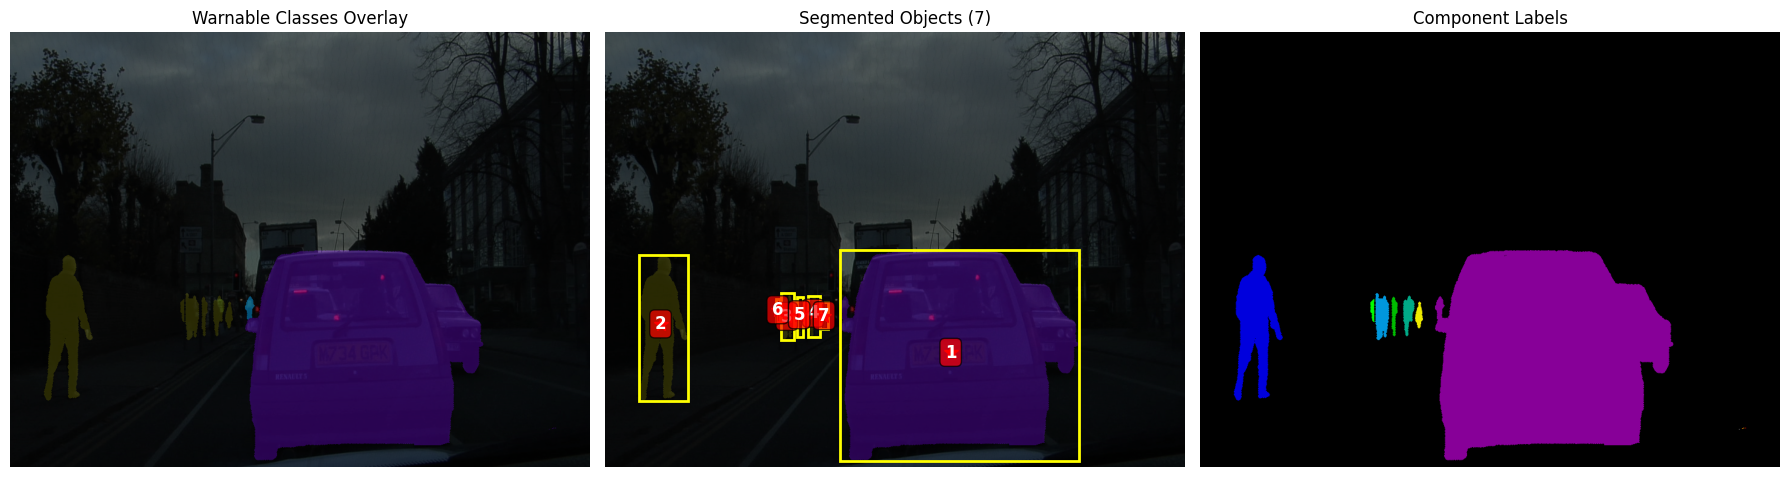


Object 1:
  Class: Car
  Area: 105965.0 pixels
  Centroid: (529.8, 571.6)
  Bounding box: (361, 389, 709, 784)
  Perimeter: 1778.6
  Eccentricity: 0.454

Object 2:
  Class: Pedestrian
  Area: 9970.0 pixels
  Centroid: (482.7, 91.4)
  Bounding box: (369, 56, 610, 137)
  Perimeter: 984.8
  Eccentricity: 0.954

Object 3:
  Class: Pedestrian
  Area: 1357.0 pixels
  Centroid: (470.2, 300.3)
  Bounding box: (432, 290, 510, 313)
  Perimeter: 245.4
  Eccentricity: 0.950

Object 4:
  Class: Pedestrian
  Area: 774.0 pixels
  Centroid: (464.9, 344.0)
  Bounding box: (436, 336, 504, 355)
  Perimeter: 176.6
  Eccentricity: 0.962

Object 5:
  Class: Pedestrian
  Area: 431.0 pixels
  Centroid: (467.5, 320.9)
  Bounding box: (438, 317, 504, 327)
  Perimeter: 165.6
  Eccentricity: 0.991

Object 6:
  Class: Pedestrian
  Area: 184.0 pixels
  Centroid: (459.2, 285.3)
  Bounding box: (442, 282, 480, 289)
  Perimeter: 92.2
  Eccentricity: 0.985

Object 7:
  Class: Pedestrian
  Area: 353.0 pixels
  Centroid

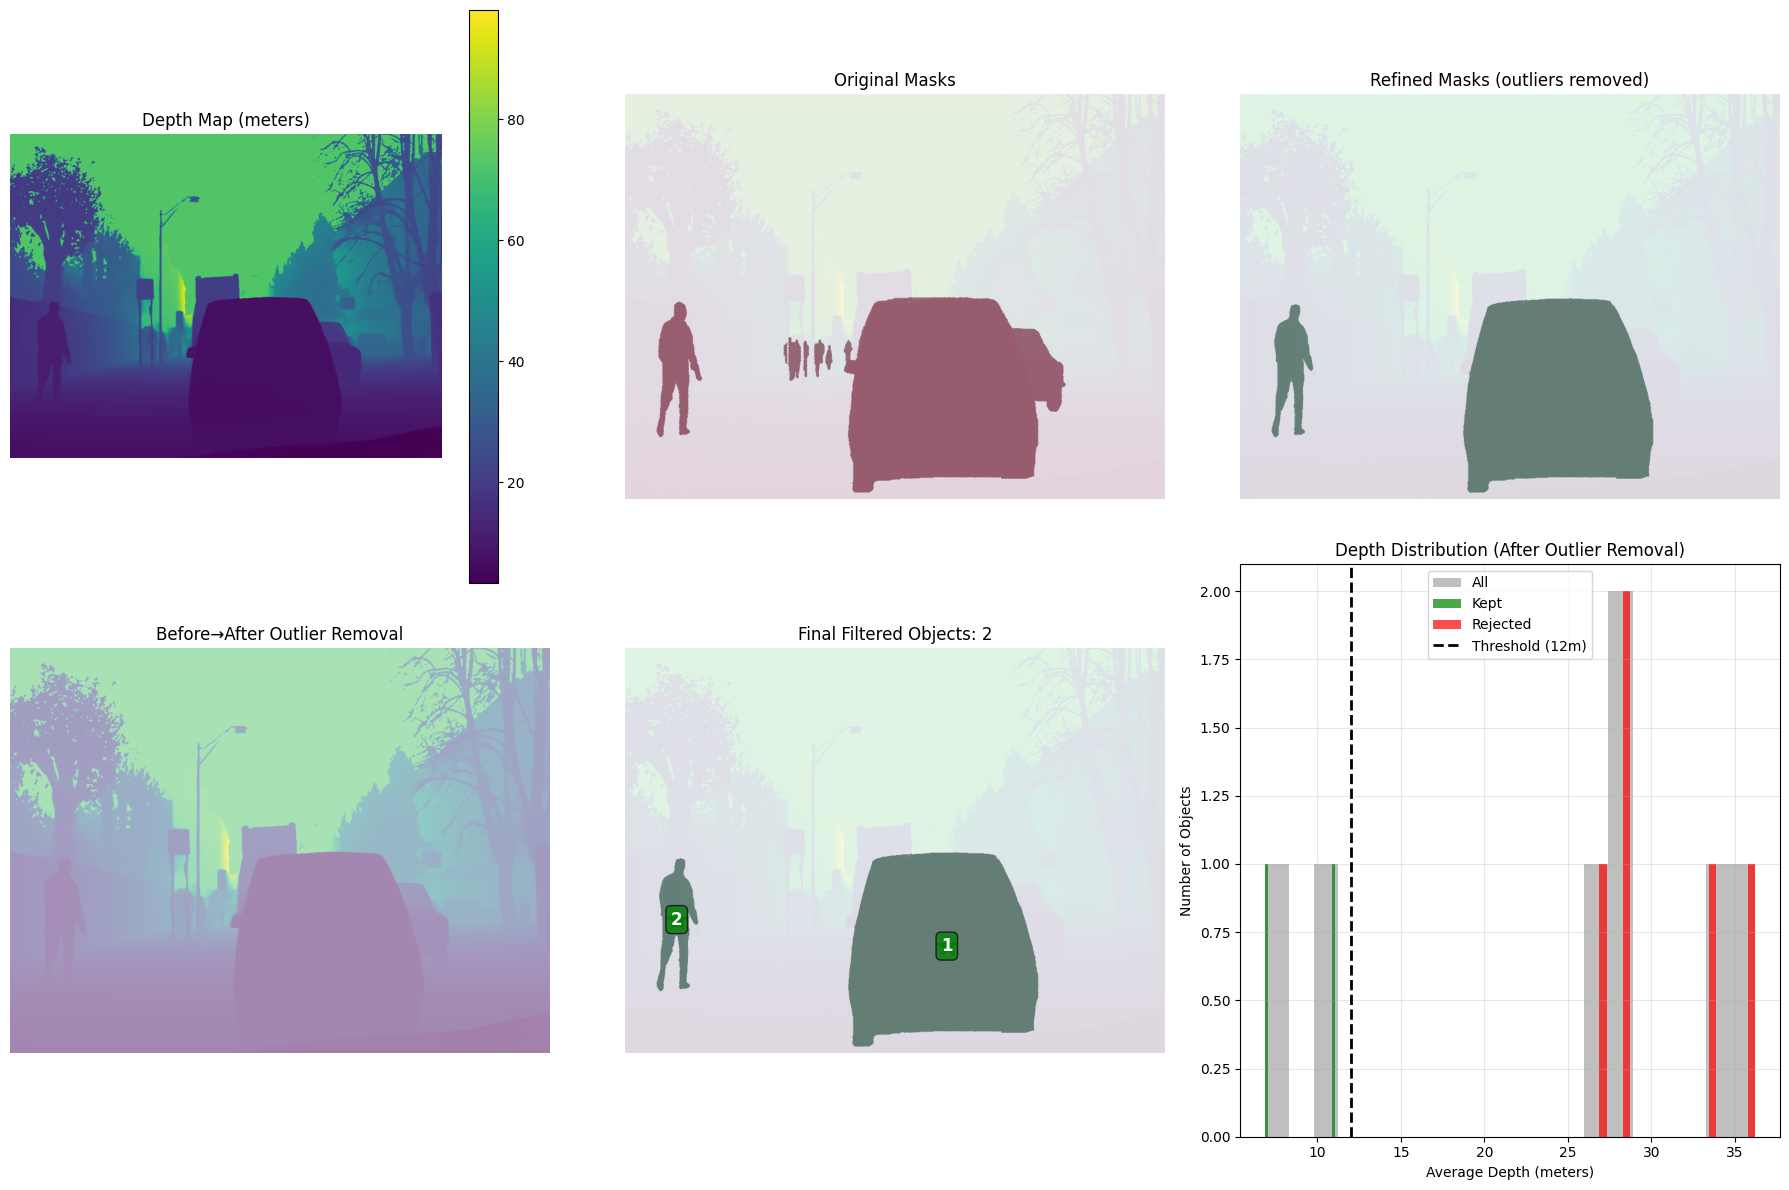


Objeto 0 - Car
Profundidad media: 6.84m
Área: 96316 pixels


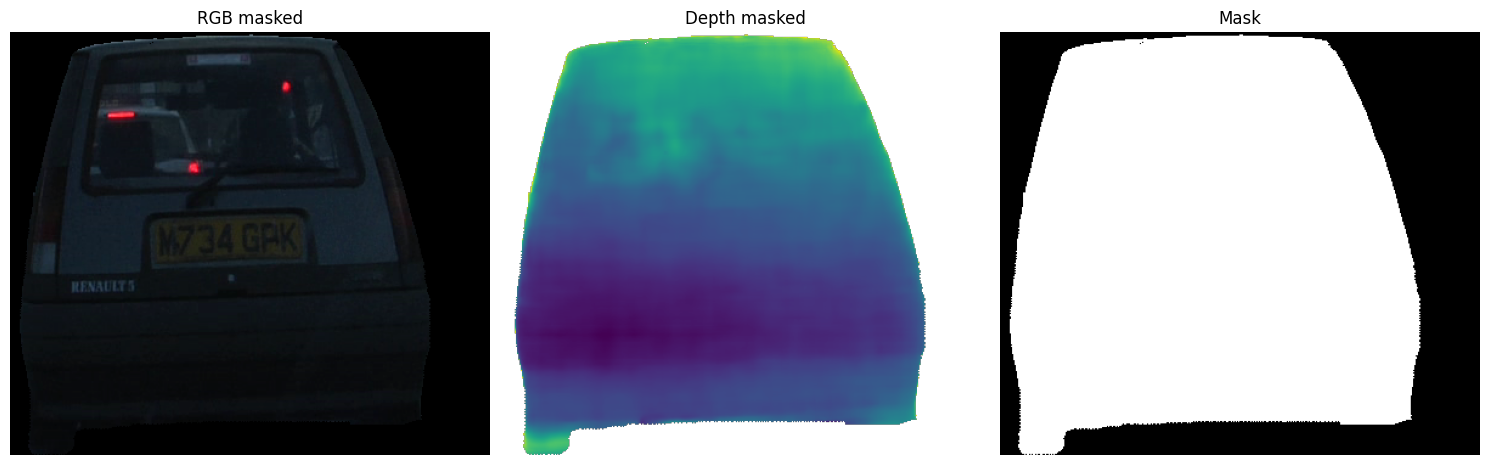


Objeto 1 - Pedestrian
Profundidad media: 11.06m
Área: 9308 pixels


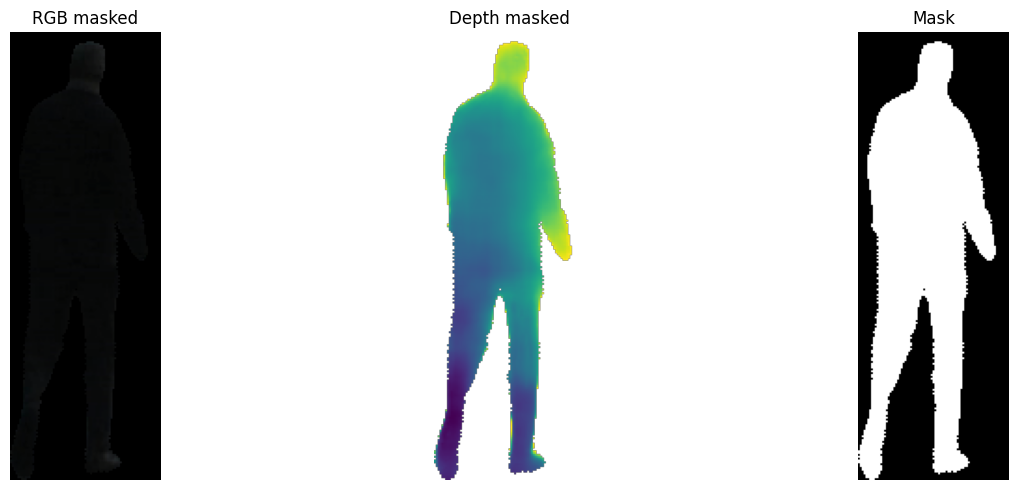

In [15]:
# 1. Segmentar objetos warnable
warnable_mask, binary_mask, objects, labels = calculate_warnable_classes_v2(
    sample_img, sample_seg, class_labels_df, warnable_classes_path, 
    alpha=0.6, min_area=100
)

# Con IQR method (recomendado para depth maps)
filtered_objects, rejected_objects, depth_stats = filter_objects_by_depth(
    objects, sample_depth, 
    depth_threshold=12, 
    outlier_method='iqr',  # 'iqr' o 'zscore'
    outlier_factor=1.5,     # 1.5 para IQR, 3.0 para zscore
    min_valid_ratio=0.3,    # Mínimo 30% de píxeles válidos
    visualize=True
)

# Extraer con máscaras refinadas
extractions = extract_filtered_objects_with_depth(
    sample_img, sample_depth, filtered_objects, 
    use_refined_mask=True  # Usa máscara sin outliers
)

# 4. Trabajar con cada objeto
for ext in extractions:
    print(f"\nObjeto {ext['object_id']} - {ext['class_name']}")
    print(f"Profundidad media: {ext['avg_depth']:.2f}m")
    print(f"Área: {ext['area']} pixels")
    
    # Visualizar
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(ext['masked_img'])
    axes[0].set_title('RGB masked')
    axes[0].axis('off')
    
    axes[1].imshow(ext['masked_depth'], cmap='viridis')
    axes[1].set_title('Depth masked')
    axes[1].axis('off')
    
    axes[2].imshow(ext['cropped_mask'], cmap='gray')
    axes[2].set_title('Mask')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# V5

In [17]:
import numpy as np
import torch
from PIL import Image
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import json

def _convert_to_numpy(data, is_depth=False):
    """Utility to convert torch/PIL to numpy efficiently (once)."""
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
        if len(data.shape) == 3 and data.shape[0] in [1, 3]:
            data = np.transpose(data, (1, 2, 0))
        if is_depth and len(data.shape) == 3:
            data = data.squeeze(-1)
        if not is_depth and (data.min() < 0 or data.max() <= 1):
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            data = data * std + mean
            data = (data * 255).clip(0, 255).astype(np.uint8)
    elif isinstance(data, Image.Image):
        data = np.array(data)
    
    if not is_depth and data.dtype != np.uint8:
        data = data.astype(np.uint8)
    
    return data


def _remove_outliers(depths, method='iqr', factor=1.5):
    """Detect outliers and return inlier mask."""
    if method == 'iqr':
        q1, q3 = np.percentile(depths, [25, 75])
        iqr = q3 - q1
        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        return (depths >= lower) & (depths <= upper)
    elif method == 'zscore':
        z_scores = np.abs((depths - np.mean(depths)) / np.std(depths))
        return z_scores < factor
    else:
        raise ValueError(f"Unknown outlier method: {method}")


def calculate_warnable_classes_with_depth(
    img, mask, img_depth, class_labels_df, warnable_classes_path,
    depth_threshold=4.5, outlier_method='iqr', outlier_factor=1.5,
    min_valid_ratio=0.3, min_area=100, alpha=0.5, visualize=True
):
    """
    Unified function: segment warnable classes AND filter by depth in one pass.
    
    Args:
        img: Input image (numpy array, PIL Image, or torch.Tensor)
        mask: Segmentation mask
        img_depth: Depth map
        class_labels_df: DataFrame with ['name', 'r', 'g', 'b']
        warnable_classes_path: Path to JSON with warnable classes
        depth_threshold: Max depth to keep object (meters)
        outlier_method: 'iqr' or 'zscore'
        outlier_factor: Factor for outlier detection
        min_valid_ratio: Min ratio of valid pixels after outlier removal
        min_area: Min area in pixels
        alpha: Transparency for overlay
        visualize: Show plots
    
    Returns:
        filtered_objects: List of objects passing all filters
        rejected_objects: List of rejected objects with reasons
        stats: Statistics dict
    """
    
    # ===== PHASE 1: Convert inputs ONCE =====
    img_np = _convert_to_numpy(img, is_depth=False)
    mask_np = _convert_to_numpy(mask, is_depth=False)
    depth_np = _convert_to_numpy(img_depth, is_depth=True)
    
    if mask_np.max() <= 1:
        mask_np = (mask_np * 255).astype(np.uint8)
    
    # Load warnable classes
    with open(warnable_classes_path, 'r') as f:
        warnable_classes = json.load(f)
    
    # ===== PHASE 2: Create binary mask and class map =====
    h, w = mask_np.shape[:2]
    warnable_binary_mask = np.zeros((h, w), dtype=bool)
    class_map = np.zeros((h, w), dtype=np.uint8)
    class_id_mapping = {}
    
    current_class_id = 1
    for idx, row in class_labels_df.iterrows():
        class_name = row['name']
        if warnable_classes.get(class_name, 0) == 1:
            r, g, b = int(row['r']), int(row['g']), int(row['b'])
            class_pixels = (mask_np[:, :, 0] == r) & \
                          (mask_np[:, :, 1] == g) & \
                          (mask_np[:, :, 2] == b)
            
            warnable_binary_mask |= class_pixels
            class_map[class_pixels] = current_class_id
            class_id_mapping[current_class_id] = {
                'name': class_name,
                'color': (r, g, b)
            }
            current_class_id += 1
    
    # ===== PHASE 3: Segment connected components =====
    labels_map = label(warnable_binary_mask, connectivity=2)
    props = regionprops(labels_map)
    
    # ===== PHASE 4: Process each object (area + depth filtering) =====
    filtered_objects = []
    rejected_objects = []
    depth_stats = {'all_depths': [], 'filtered_depths': [], 'rejected_depths': []}
    
    print(f"\nProcessing {len(props)} candidate objects")
    print(f"Filters: min_area={min_area}, depth<{depth_threshold}m, {outlier_method} outliers")
    print("=" * 80)
    
    for i, prop in enumerate(props):
        # Filter by area first (cheap check)
        if prop.area < min_area:
            rejected_objects.append({
                'label': prop.label,
                'area': prop.area,
                'rejection_reason': f'area_too_small ({prop.area} < {min_area})'
            })
            continue
        
        # Get object mask and class (ONCE)
        object_mask = labels_map == prop.label
        object_classes = class_map[object_mask]
        most_common_class = np.bincount(object_classes[object_classes > 0]).argmax()
        class_info = class_id_mapping[most_common_class]
        
        # Get depth values (ONCE)
        object_depths = depth_np[object_mask]
        valid_mask = np.isfinite(object_depths) & (object_depths >= 0)
        valid_depths = object_depths[valid_mask]
        
        if len(valid_depths) == 0:
            rejected_objects.append({
                'label': prop.label,
                'class_name': class_info['name'],
                'area': prop.area,
                'rejection_reason': 'no_valid_depth'
            })
            print(f"Object {i+1} ({class_info['name']}): No valid depth - REJECTED")
            continue
        
        # Calculate initial stats
        initial_mean = np.mean(valid_depths)
        
        # Remove outliers
        inlier_mask = _remove_outliers(valid_depths, outlier_method, outlier_factor)
        inlier_depths = valid_depths[inlier_mask]
        
        valid_ratio = len(inlier_depths) / len(valid_depths)
        if valid_ratio < min_valid_ratio:
            rejected_objects.append({
                'label': prop.label,
                'class_name': class_info['name'],
                'area': prop.area,
                'rejection_reason': f'too_many_outliers ({valid_ratio:.1%})'
            })
            print(f"Object {i+1} ({class_info['name']}): Too many outliers - REJECTED")
            continue
        
        # Calculate final depth stats (vectorized)
        avg_depth = np.mean(inlier_depths)
        depth_stats['all_depths'].append(avg_depth)
        
        # Create refined mask efficiently
        refined_mask = object_mask.copy()
        y_coords, x_coords = np.where(object_mask)
        
        # Map valid pixels to their inlier status
        valid_idx = 0
        for idx in range(len(object_depths)):
            if valid_mask[idx]:
                if not inlier_mask[valid_idx]:
                    refined_mask[y_coords[idx], x_coords[idx]] = False
                valid_idx += 1
        
        refined_area = np.sum(refined_mask)
        
        # Build object info
        obj_info = {
            'label': prop.label,
            'class_id': most_common_class,
            'class_name': class_info['name'],
            'class_color': class_info['color'],
            'area': prop.area,
            'refined_area': refined_area,
            'centroid': prop.centroid,
            'bbox': prop.bbox,
            'mask': object_mask,
            'refined_mask': refined_mask,
            'avg_depth': avg_depth,
            'min_depth': np.min(inlier_depths),
            'max_depth': np.max(inlier_depths),
            'std_depth': np.std(inlier_depths),
            'median_depth': np.median(inlier_depths),
            'n_outliers': len(valid_depths) - len(inlier_depths),
            'outlier_ratio': 1 - valid_ratio,
            'initial_mean': initial_mean,
            'depth_change': initial_mean - avg_depth
        }
        
        # Apply depth threshold
        if avg_depth < depth_threshold:
            filtered_objects.append(obj_info)
            depth_stats['filtered_depths'].append(avg_depth)
            status = "✓ KEPT"
        else:
            obj_info['rejection_reason'] = f'depth_too_far ({avg_depth:.2f}m)'
            rejected_objects.append(obj_info)
            depth_stats['rejected_depths'].append(avg_depth)
            status = "✗ REJECTED"
        
        print(f"Object {i+1} ({class_info['name']}): {status}")
        print(f"  Depth: {initial_mean:.2f}→{avg_depth:.2f}m | "
              f"Range: {obj_info['min_depth']:.2f}-{obj_info['max_depth']:.2f}m | "
              f"Outliers: {obj_info['n_outliers']} ({obj_info['outlier_ratio']*100:.1f}%)")
    
    print("=" * 80)
    print(f"Results: {len(filtered_objects)} kept, {len(rejected_objects)} rejected")
    
    # ===== PHASE 5: Visualization =====
    if visualize and len(filtered_objects) > 0:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Original with overlay
        axes[0, 0].imshow(img_np)
        warnable_vis = mask_np.copy()
        warnable_vis[~warnable_binary_mask] = 0
        axes[0, 0].imshow(warnable_vis, alpha=alpha)
        axes[0, 0].set_title('Warnable Classes Overlay')
        axes[0, 0].axis('off')
        
        # Depth map
        im = axes[0, 1].imshow(depth_np, cmap='viridis')
        axes[0, 1].set_title('Depth Map')
        axes[0, 1].axis('off')
        plt.colorbar(im, ax=axes[0, 1])
        
        # Segmented objects with bboxes
        axes[0, 2].imshow(img_np)
        colored_labels = np.zeros_like(img_np)
        for obj in filtered_objects:
            colored_labels[obj['refined_mask']] = obj['class_color']
        axes[0, 2].imshow(colored_labels, alpha=alpha)
        
        for i, obj in enumerate(filtered_objects):
            y, x = obj['centroid']
            axes[0, 2].plot(x, y, 'r*', markersize=10)
            axes[0, 2].text(x, y, str(i+1), color='white', fontsize=12,
                          ha='center', va='center', weight='bold',
                          bbox=dict(boxstyle='round', facecolor='red', alpha=0.7))
            
            min_row, min_col, max_row, max_col = obj['bbox']
            rect = plt.Rectangle((min_col, min_row), max_col-min_col, max_row-min_row,
                                fill=False, edgecolor='yellow', linewidth=2)
            axes[0, 2].add_patch(rect)
        
        axes[0, 2].set_title(f'Segmented Objects ({len(filtered_objects)})')
        axes[0, 2].axis('off')
        
        # Refined masks
        refined_mask_vis = np.zeros_like(depth_np, dtype=bool)
        for obj in filtered_objects:
            refined_mask_vis |= obj['refined_mask']
        
        axes[1, 0].imshow(depth_np, cmap='viridis', alpha=0.3)
        axes[1, 0].imshow(refined_mask_vis, cmap='Greens', alpha=0.5)
        axes[1, 0].set_title('Refined Masks (outliers removed)')
        axes[1, 0].axis('off')
        
        # Depth values
        axes[1, 1].imshow(depth_np, cmap='viridis', alpha=0.5)
        for obj in filtered_objects:
            y, x = obj['centroid']
            axes[1, 1].plot(x, y, 'g*', markersize=15)
            depth_text = f"{obj['avg_depth']:.1f}m"
            axes[1, 1].text(x, y+20, depth_text, color='green', fontsize=10,
                          ha='center', weight='bold',
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        axes[1, 1].set_title('Final Objects with Depth')
        axes[1, 1].axis('off')
        
        # Histogram
        if depth_stats['all_depths']:
            axes[1, 2].hist(depth_stats['all_depths'], bins=20, alpha=0.5, 
                          label='All', color='gray')
            if depth_stats['filtered_depths']:
                axes[1, 2].hist(depth_stats['filtered_depths'], bins=20, alpha=0.7,
                              label='Kept', color='green')
            if depth_stats['rejected_depths']:
                axes[1, 2].hist(depth_stats['rejected_depths'], bins=20, alpha=0.7,
                              label='Rejected', color='red')
            axes[1, 2].axvline(depth_threshold, color='black', linestyle='--',
                             linewidth=2, label=f'Threshold ({depth_threshold}m)')
            axes[1, 2].set_xlabel('Average Depth (meters)')
            axes[1, 2].set_ylabel('Count')
            axes[1, 2].set_title('Depth Distribution')
            axes[1, 2].legend()
            axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return filtered_objects, rejected_objects, depth_stats


def extract_object_crops(img, img_depth, filtered_objects, use_refined_mask=True):
    """
    Extract cropped regions efficiently (no redundant conversions).
    
    Args:
        img: Original image (already numpy from previous function)
        img_depth: Depth map (already numpy)
        filtered_objects: List of filtered objects
        use_refined_mask: Use refined mask (without outliers)
    
    Returns:
        extractions: List of dicts with cropped data
    """
    # Images should already be numpy from calculate_warnable_classes_with_depth
    # But handle edge case where user passes torch tensors
    img_np = _convert_to_numpy(img, is_depth=False) if isinstance(img, torch.Tensor) else img
    depth_np = _convert_to_numpy(img_depth, is_depth=True) if isinstance(img_depth, torch.Tensor) else img_depth
    
    extractions = []
    
    for i, obj in enumerate(filtered_objects):
        mask_to_use = obj['refined_mask'] if use_refined_mask else obj['mask']
        min_row, min_col, max_row, max_col = obj['bbox']
        
        # Crop efficiently (views where possible)
        cropped_img = img_np[min_row:max_row, min_col:max_col].copy()
        cropped_depth = depth_np[min_row:max_row, min_col:max_col].copy()
        cropped_mask = mask_to_use[min_row:max_row, min_col:max_col]
        
        # Apply mask
        masked_img = cropped_img.copy()
        masked_img[~cropped_mask] = 0
        
        masked_depth = cropped_depth.copy()
        masked_depth[~cropped_mask] = np.nan
        
        extractions.append({
            'object_id': i,
            'class_name': obj['class_name'],
            'avg_depth': obj['avg_depth'],
            'min_depth': obj['min_depth'],
            'max_depth': obj['max_depth'],
            'std_depth': obj['std_depth'],
            'median_depth': obj['median_depth'],
            'n_outliers': obj['n_outliers'],
            'outlier_ratio': obj['outlier_ratio'],
            'depth_change': obj['depth_change'],
            'cropped_img': cropped_img,
            'cropped_depth': cropped_depth,
            'cropped_mask': cropped_mask,
            'masked_img': masked_img,
            'masked_depth': masked_depth,
            'bbox': obj['bbox'],
            'centroid': obj['centroid'],
            'area': obj['refined_area'],
            'original_area': obj['area']
        })
    
    return extractions


Processing 10 candidate objects
Filters: min_area=100, depth<12m, iqr outliers
Object 1 (Car): ✓ KEPT
  Depth: 7.79→6.84m | Range: 6.56-7.48m | Outliers: 9649 (9.1%)
Object 2 (Pedestrian): ✓ KEPT
  Depth: 11.22→11.06m | Range: 10.59-11.65m | Outliers: 662 (6.6%)
Object 3 (Pedestrian): ✗ REJECTED
  Depth: 27.99→28.69m | Range: 26.22-30.53m | Outliers: 238 (17.5%)
Object 4 (Pedestrian): ✗ REJECTED
  Depth: 34.83→33.57m | Range: 25.12-55.83m | Outliers: 32 (4.1%)
Object 5 (Pedestrian): ✗ REJECTED
  Depth: 26.77→26.87m | Range: 23.26-30.54m | Outliers: 19 (4.4%)
Object 6 (Pedestrian): ✗ REJECTED
  Depth: 28.64→28.64m | Range: 21.10-36.91m | Outliers: 0 (0.0%)
Object 7 (Pedestrian): ✗ REJECTED
  Depth: 36.15→36.23m | Range: 34.93-37.38m | Outliers: 20 (5.7%)
Results: 2 kept, 8 rejected


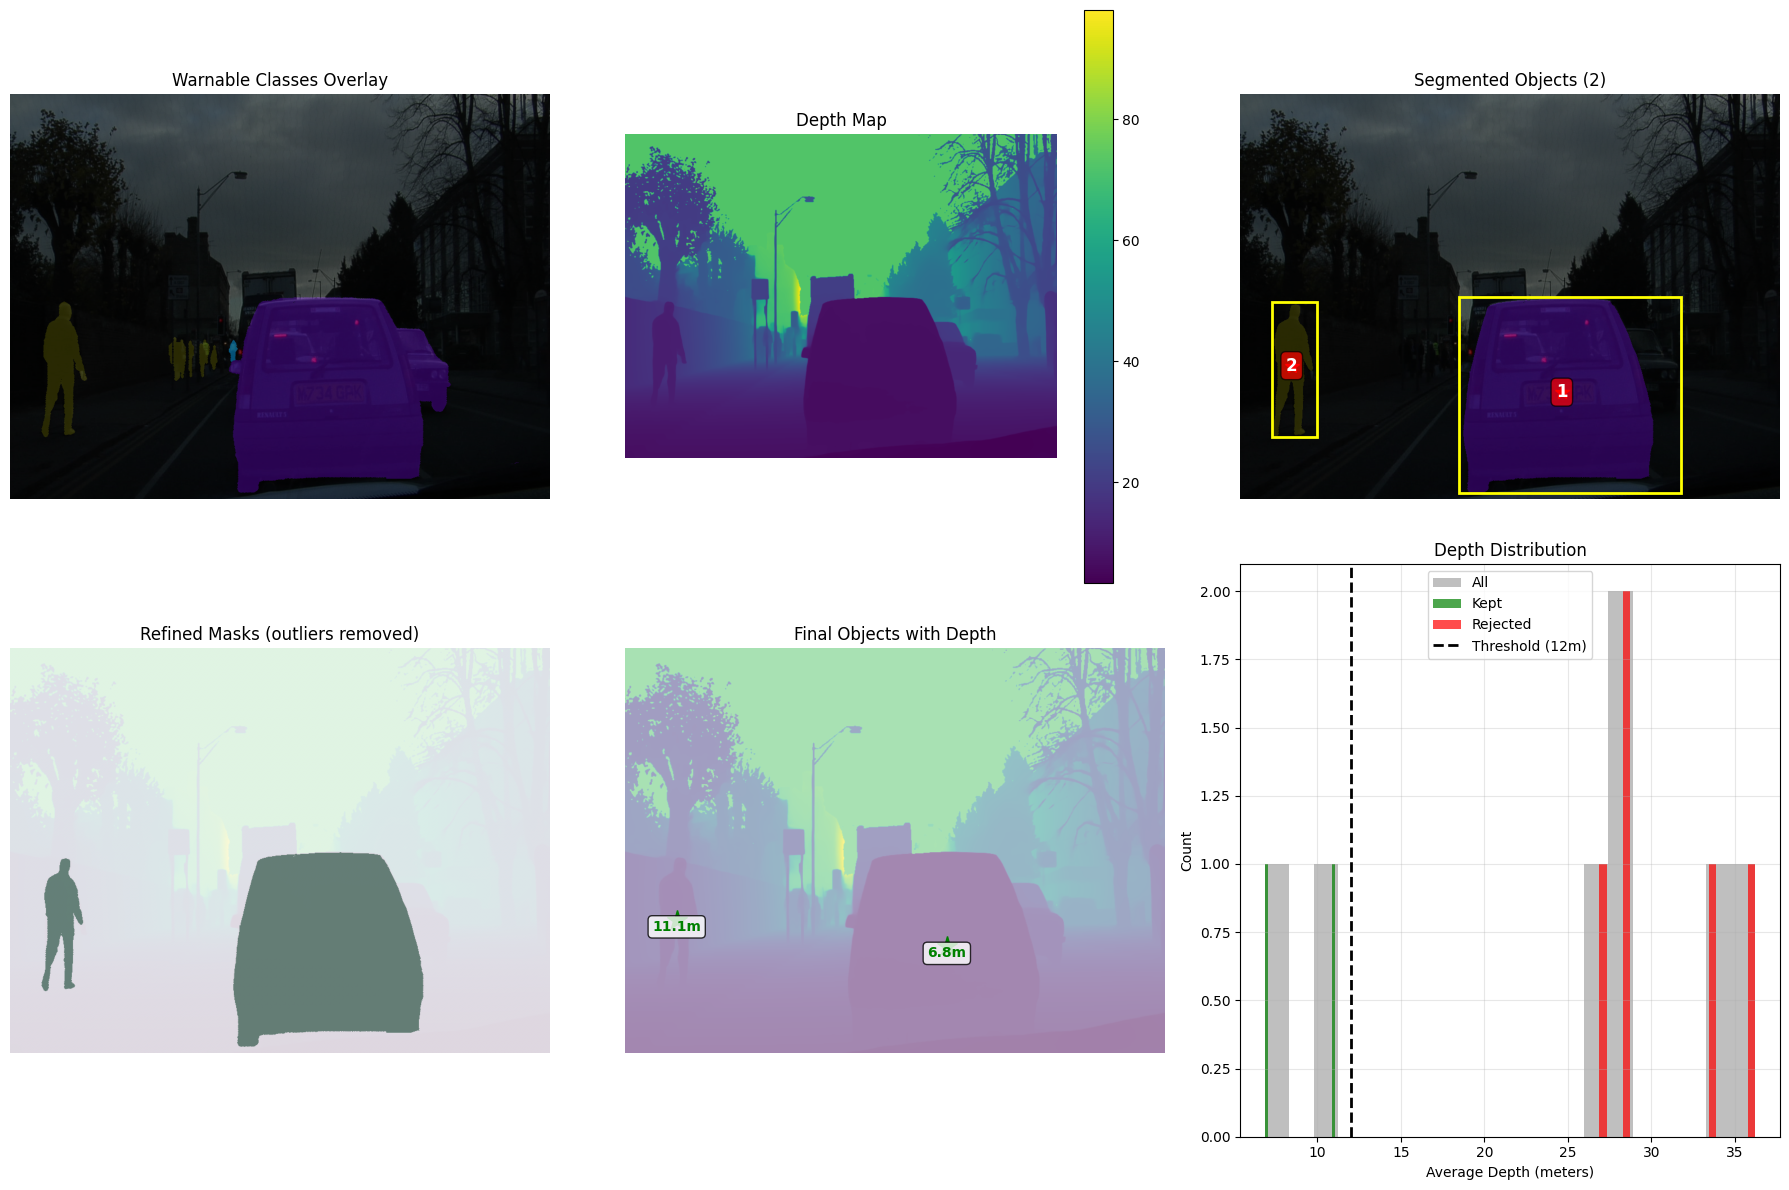


Object 0 - Car
Depth: 6.84m ± 0.17m
Area: 96316 pixels


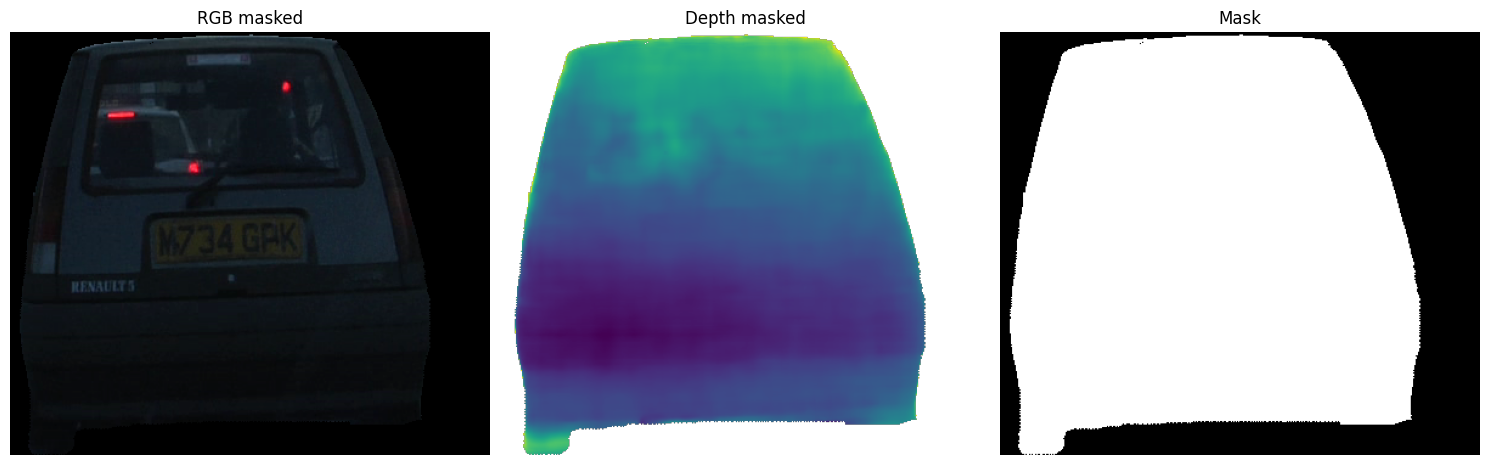


Object 1 - Pedestrian
Depth: 11.06m ± 0.22m
Area: 9308 pixels


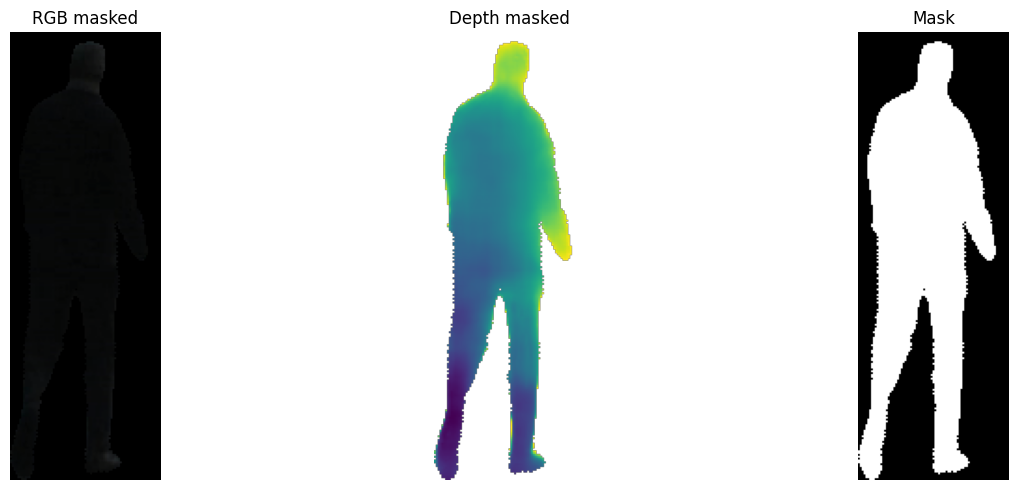

In [18]:
# ===== USAGE EXAMPLE =====

# Single unified call instead of 3 separate functions
filtered_objects, rejected_objects, stats = calculate_warnable_classes_with_depth(
    sample_img, sample_seg, sample_depth,
    class_labels_df, warnable_classes_path,
    depth_threshold=12,
    outlier_method='iqr',
    outlier_factor=1.5,
    min_valid_ratio=0.3,
    min_area=100,
    alpha=0.6,
    visualize=True
)

# Extract crops (now much faster - no conversions)
extractions = extract_object_crops(
    sample_img, sample_depth, filtered_objects,
    use_refined_mask=True
)

# Visualize individual objects
for ext in extractions:
    print(f"\nObject {ext['object_id']} - {ext['class_name']}")
    print(f"Depth: {ext['avg_depth']:.2f}m ± {ext['std_depth']:.2f}m")
    print(f"Area: {ext['area']} pixels")
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(ext['masked_img'])
    axes[0].set_title('RGB masked')
    axes[0].axis('off')
    
    axes[1].imshow(ext['masked_depth'], cmap='viridis')
    axes[1].set_title('Depth masked')
    axes[1].axis('off')
    
    axes[2].imshow(ext['cropped_mask'], cmap='gray')
    axes[2].set_title('Mask')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()